# Predict Intervention Responsiveness

This notebook holds the code for the main analysis of the paper "Peer Perceptions Emerge as Key Predictors in Multimodal Models of Digital Alcohol Intervention Effectiveness" submitted to npj Digital Medicine.

**Data modalities for the main analysis are:**
- `b1_alcohol_self`: Self-reported individual alcohol use and related behaviors.
- `b2_group_subjective`: Participant perceptions of their social group’s drinking norms, attitudes, and approval. How much a participant perceives their peers to drink.
- `b3_group_sociometric`: Social network–derived measures of group structure and connections.
- `b4_brain`: Preprocessed MRI-derived measures of brain activity and connectivity in alcohol-related tasks.
- `b5_demographic`: Basic participant characteristics such as age, gender, and income.
- `b6_psychometric`: Standardized questionnaire-based measures of psychological traits and states.

**Additional analysis:**
- `b7_objective_group_drinking`: Aggregated group-level drinking data (how much a participant's peers actually drink).
(Analyses with this dataframe are commented - they are left in the code so as to make the processing of this data transparent. However, this analysis was added after the main analysis to compare the predictive utility of objective group drinking compared to group perceptions. This is reported in the supplements of the above paper.)

**External test set:**
- `b2_group_subjective_study2`: Participant perceptions of their social group’s drinking norms, attitudes, and approval in an independent sample.


In [1]:
# Standard libraries
import os
import time
import warnings
from copy import deepcopy
from itertools import combinations, chain

# Progress bar
from tqdm import tqdm

# Data manipulation
import numpy as np
import pandas as pd
from collections import Counter

# Statistical analysis
from scipy.stats import norm
from scipy.stats import spearmanr
from pygam import LogisticGAM, s, f

# Visualization
import shap
import seaborn as sns

# Serialization
import joblib

# Custom
from pre_processing import *
from training import *
from plotting import *
from testing import *

# Suppress warnings
warnings.filterwarnings('ignore')


Set seed to replicate the exact results from the paper. Set to `None` to run without random seed (note that this can lead to small deviations in outcome metrics due to randomness in the CV and test process).

Please note that the social network data (`b3_group_sociometric`) cannot be publicly provided due to privacy concerns. Running the script without this feature domain may cause some deviations in results from those reported in the main manuscript. Use and processing of this dataframe were left in the notebook but commented so that the processing of this data is still transparent. However, results are qualitatively reproducible and the code shows our procedure in processing and analysing the data.

In [2]:
SEED = 321
# SEED = None

In [3]:
if SEED:
    np.random.seed(SEED)

## Pre-Processing

### Define threshold for responsiveness

Indicate change threshold that qualifies a participant as responsive vs non-responsive

In [4]:
# DEFINE RESPONSIVENESS
# avg reduction in drinking occasions between active and control weeks
def_response_drink_occasions = -1

### Load data

In [ ]:
output_dir = "../../results"

data_study1 = pd.read_csv('../data/intervention_time/osf_study1.csv')
data_study2 = pd.read_csv('../data/intervention_time/osf_study2.csv')

# Study 1 baseline data (train/val input)
b1_alcohol_self = pd.read_csv('../data/baseline/alcoholself_bucket280225.csv', index_col=0)
b2_group_subjective = pd.read_csv('../data/baseline/subjective_grouperceptions_280225.csv', index_col=0)
b3_group_sociometric = pd.read_csv('../data/baseline/data_social.csv')
b4_brain = pd.read_csv('../data/baseline/brain_bucket_280225.csv', index_col=0)
b5_demographic = pd.read_csv('../data/baseline/demographic_bucket280225.csv', index_col=0)
b6_psychometric = pd.read_csv('../data/baseline/psychometrics_bucket280225.csv', index_col=0)

# # Added analysis - To evaluate performance of objective drinking metrics
# b7_objective_group_drinking = pd.read_csv('../data/added_analysis/social_group_drinking.csv', index_col=0)

# Study 2 peer perception data (test input)
b2_group_subjective_study2 = pd.read_csv('../data/baseline/subjective_grouperceptions_test.csv')
baseline_demo_study2 = pd.read_csv('../data/baseline/demo_study2_full.csv')
baseline_demo_all = pd.read_csv('../data/baseline/00_baseline_survey.csv')

# Study 1 & 2 drinking/responsiveness data (output -> prediction target)
if def_response_drink_occasions == -1:
    responsive_study1 = pd.read_csv('../data/intervention_time/responsiveness_study1.csv', index_col=0).reset_index()
elif def_response_drink_occasions == -0.5:
    responsive_study1 = pd.read_csv('../data/intervention_time/responsiveness_study1_-0_5.csv', index_col=0).reset_index()
elif def_response_drink_occasions == -2:
    responsive_study1 = pd.read_csv('../data/intervention_time/responsiveness_study1_-2.csv', index_col=0).reset_index()
elif def_response_drink_occasions == 'who':
    responsive_study1 = pd.read_csv('../data/intervention_time/responsiveness_study1_who_rdl.csv', index_col=0).reset_index()
elif def_response_drink_occasions == -0.9:
    responsive_study1 = pd.read_csv('../data/intervention_time/responsiveness_study1_-0.9.csv', index_col=0).reset_index()
elif def_response_drink_occasions == -1.5:
    responsive_study1 = pd.read_csv('../data/intervention_time/responsiveness_study1_-1.5.csv', index_col=0).reset_index()
elif def_response_drink_occasions == -0.1:
    responsive_study1 = pd.read_csv('../data/intervention_time/responsiveness_study1_-0.1.csv', index_col=0).reset_index()

responsive_study2 = pd.read_csv('../data/intervention_time/responsiveness_study2.csv', index_col=0).reset_index()

In [6]:
data_study1_control = data_study1[data_study1.condition == 'control']
data_study2_control = data_study2[data_study2.condition == 'control']

len(data_study1_control['id'].unique())
len(data_study2_control['id'].unique())


71

In [7]:
# Check for duplicates within each DataFrame
duplicates_study1 = responsive_study1['id'].duplicated().any()
duplicates_study2 = responsive_study2['id'].duplicated().any()

## TEST independently for one condition [mindful | perspective]
# responsive_study1 = responsive_study1[responsive_study1.condition == 'mindful']
# responsive_study2 = responsive_study2[responsive_study2.condition == 'mindful']
## ---
# responsive_study1 = responsive_study1[responsive_study1.condition == 'perspective']
# responsive_study2 = responsive_study2[responsive_study2.condition == 'perspective']

print(f"Study 1 has duplicates: {duplicates_study1}")
print(f"Study 2 has duplicates: {duplicates_study2}")

# Check for overlapping IDs between the two studies
ids_study1 = set(responsive_study1['id'])
ids_study2 = set(responsive_study2['id'])
overlap = ids_study1.intersection(ids_study2)

print(f"Number of overlapping IDs: {len(overlap)}") # Should be zero
if overlap:
    print(f"Overlapping IDs: {overlap}")


Study 1 has duplicates: False
Study 2 has duplicates: False
Number of overlapping IDs: 0


In [8]:
EXCLUDE_VARS = [
    'group', 'condition', 'active',
    'control', 'difference_drinks_occasions']

responsive_study1.drop(columns=EXCLUDE_VARS, inplace=True, errors='ignore')
responsive_study2.drop(columns=EXCLUDE_VARS, inplace=True, errors='ignore')


In [9]:
responsive_study2.head()

,id,responsive
0,muri015,0
1,muri016,0
2,muri018,0
3,muri023,1
4,muri028,0


### Merge Baseline and Target Data

In [10]:
# Training datasets -> Study 1
b1_alcohol_self_response = pd.merge(b1_alcohol_self, responsive_study1, on='id', how='inner')
b2_group_subjective_response = pd.merge(b2_group_subjective, responsive_study1, on='id', how='inner')
b2_group_subjective_response_old = pd.merge(responsive_study1, responsive_study1, on='id', how='inner')
b3_group_sociometric_response = pd.merge(b3_group_sociometric, responsive_study1, on='id', how='inner')
b4_brain_response = pd.merge(b4_brain, responsive_study1, on='id', how='inner')
b5_demographic_response = pd.merge(b5_demographic, responsive_study1, on='id', how='inner')
b6_psychometric_response = pd.merge(b6_psychometric, responsive_study1, on='id', how='inner')

# b7_objective_group_drinking_response = pd.merge(b7_objective_group_drinking, responsive_study1, on='id', how='inner')

print(f'Total IDs Study 1: {len(b1_alcohol_self_response)}')
print(f'Responsive IDs Study 1: {b1_alcohol_self_response[b1_alcohol_self_response["responsive"] == 1]["id"].nunique()}')
print('----------')
# Testing dataset -> Study 2
b2_group_subjective_test = pd.merge(b2_group_subjective_study2, responsive_study2, on='id', how='inner')
print(f'Total IDs Study 2: {len(b2_group_subjective_test)}')
print(f'Responsive IDs Study 2: {b2_group_subjective_test[b2_group_subjective_test["responsive"] == 1]["id"].nunique()}')

Total IDs Study 1: 69
Responsive IDs Study 1: 16
----------
Total IDs Study 2: 114
Responsive IDs Study 2: 14


In [11]:
dataframes = {
    # 'alc_self': b1_alcohol_self_response,
    'group_sub': b2_group_subjective_response,
    # 'group_socio': b3_group_sociometric_response,
    # 'brain': b4_brain_response,
    # 'demo': b5_demographic_response,
    # 'psych': b6_psychometric_response
}

for key, df in dataframes.items():
    print(f"Missing values in '{key}':")
    print(df.isna().sum())
    print()  # for spacing between outputs

Missing values in 'group_sub':
id                  0
avg_alcmost_freq    0
avg_alcmost         0
alc_norm_5_r        0
groupAtt_alc        0
groupAtt_binge      0
responsive          0
dtype: int64



## Feature Selection

### Find highly correlated features within buckets
Find redundancy in features if they are highly correlated

In [12]:
dataframes = {
    'alc_self': b1_alcohol_self_response,
    'group_sub': b2_group_subjective_response,
    # 'group_socio': b3_group_sociometric_response,
    'brain': b4_brain_response,
    'demo': b5_demographic_response,
    'psych': b6_psychometric_response
}

In [13]:
TARGET_VAR = 'responsive'

In [14]:
correlated_features = find_highly_correlated_features(dataframes, threshold=0.8, target_var=TARGET_VAR)

# Display results
for name, pairs in correlated_features.items():
    print(f"\n{name} - Highly Correlated Features:")
    for col1, col2, corr_value in pairs:
        print(f"  {col1} ↔ {col2} : Correlation = {corr_value:.2f}")



alc_self - Highly Correlated Features:

group_sub - Highly Correlated Features:

brain - Highly Correlated Features:
  ROI_alc_react_v_rest_neurosynth_reward ↔ ROI_alc_react_v_rest_neurosynth_cogcontrol : Correlation = 0.81
  ROI_alc_react_v_rest_neurosynth_reward ↔ ROI_alc_react_v_rest_neurosynth_craving : Correlation = 0.87
  ROI_alc_react_v_rest_neurosynth_reward ↔ ROI_alc_react_v_rest_neurosynth_emoreg : Correlation = 0.89
  mentalizing ↔ reward : Correlation = 0.84

demo - Highly Correlated Features:

psych - Highly Correlated Features:
  ACS_mean ↔ ACS_focus : Correlation = 0.90
  DERS_strategies ↔ DERS_mean : Correlation = 0.90
  BIS_attention_total ↔ BIS_mean : Correlation = 0.80


### Remove highly correlated features:

In [15]:
# Choice is made manually 

dataframes['brain'].drop(columns=['reward', 'ROI_alc_react_v_rest_neurosynth_cogcontrol', 'ROI_alc_react_v_rest_neurosynth_craving', \
                                  'ROI_alc_react_v_rest_neurosynth_emoreg'], inplace=True)

# dataframes['group_socio'].drop(columns=['leaders_deg_in', 'goToBad_deg_in'], inplace=True)

dataframes['psych'].drop(columns=['ACS_focus', 'DERS_strategies', 'BIS_attention_total'], inplace=True)

In [16]:
# Check that all within-category correlations are gone
correlated_features = find_highly_correlated_features(dataframes, threshold=0.8)

for name, pairs in correlated_features.items():
    print(f"\n{name} - Highly Correlated Features:")
    for col1, col2, corr_value in pairs:
        print(f"  {col1} ↔ {col2} : Correlation = {corr_value:.2f}")



alc_self - Highly Correlated Features:

group_sub - Highly Correlated Features:

brain - Highly Correlated Features:

demo - Highly Correlated Features:

psych - Highly Correlated Features:


In [17]:
# Number of remaining features per category
{key: df.shape[1] for key, df in dataframes.items()}

{'alc_self': 18, 'group_sub': 7, 'brain': 6, 'demo': 7, 'psych': 19}

### Data cleaning

In [18]:
# 1) Count initial number of unique IDs in each DataFrame
print("Initial ID counts per dataframe:")
initial_counts = {name: df['id'].nunique() for name, df in dataframes.items()}
for name, count in initial_counts.items():
    print(f"  {name}: {count}")

# 2) Identify and remove IDs with >10 missing values across all dataframes
# Count missing values per ID across all dataframes
missing_counts = Counter()
for df in dataframes.values():
    id_missing = df.set_index('id').isnull().sum(axis=1)
    for idx, val in id_missing.items():
        if val > 0:
            missing_counts[idx] += val

# Get IDs with >10 missing values in total
bad_ids = {id_ for id_, miss_count in missing_counts.items() if miss_count > 10}

# Drop those IDs from all dataframes
for name in dataframes:
    dataframes[name] = dataframes[name][~dataframes[name]['id'].isin(bad_ids)]

print("\nID counts after removing IDs with >10 total missing features:")
post_clean_counts = {name: df['id'].nunique() for name, df in dataframes.items()}
for name, count in post_clean_counts.items():
    print(f"  {name}: {count}")

# 3) Intersect IDs: keep only IDs present in all dataframes
common_ids = set.intersection(*[set(df['id']) for df in dataframes.values()])
for name in dataframes:
    dataframes[name] = dataframes[name][dataframes[name]['id'].isin(common_ids)]

# 4) Final N
final_N = len(common_ids)
for name in dataframes:
    dataframes[name] = dataframes[name][dataframes[name]['id'].isin(common_ids)]
print(f"\nFinal number of participants present in all dataframes: N = {final_N}")


Initial ID counts per dataframe:
  alc_self: 69
  group_sub: 69
  brain: 68
  demo: 69
  psych: 69

ID counts after removing IDs with >10 total missing features:
  alc_self: 68
  group_sub: 68
  brain: 67
  demo: 68
  psych: 68

Final number of participants present in all dataframes: N = 67


In [19]:
## Study 2
b2_group_subjective_test

# 1) Count initial number of unique IDs in each DataFrame
print("Initial ID counts study 2:")
initial_counts = b2_group_subjective_test['id'].nunique()
print(f"  group_subjective_test: {initial_counts}")

# Remove rows with more than 1 missing feature
b2_group_subjective_test = b2_group_subjective_test[b2_group_subjective_test.isnull().sum(axis=1) <= 1]

# Check how many IDs remain
remaining_ids = b2_group_subjective_test['id'].nunique()
print(f"  group_subjective_test (after removing >1 missing): {remaining_ids}")
print(f"Responsive: {b2_group_subjective_test['responsive'].sum()} out of {b2_group_subjective_test.shape[0]}")


Initial ID counts study 2:
  group_subjective_test: 114
  group_subjective_test (after removing >1 missing): 114
Responsive: 14 out of 114


## Sample Characteristics Study 1

In [20]:
# Print number of unique 'id's in each dataframe
for name, df in dataframes.items():
    unique_count = df['id'].nunique()
    print(f"{name}: {unique_count} unique IDs")


alc_self: 67 unique IDs
group_sub: 67 unique IDs
brain: 67 unique IDs
demo: 67 unique IDs
psych: 67 unique IDs


In [21]:
# Step 1: Get common IDs
common_ids = set.intersection(*[set(df['id']) for df in dataframes.values()])

# Step 2: Filter each DataFrame to keep only rows with common IDs
for name in dataframes:
    dataframes[name] = dataframes[name][dataframes[name]['id'].isin(common_ids)]


In [22]:
# Step 1: Get common IDs
common_ids = set.intersection(*[set(df['id']) for df in dataframes.values()])

# Step 2: Filter demographics
demo_filtered = dataframes['demo'][dataframes['demo']['id'].isin(common_ids)]
demo_filtered["id"].to_csv("../data/study_1_ids.csv")

# Step 3: Compute summaries
N = demo_filtered.shape[0]
age_mean = round(demo_filtered['age'].mean(), 2)
age_sd = round(demo_filtered['age'].std(), 2)

# Gender distribution
gender_counts = demo_filtered['gender_numeric'].value_counts().sort_index()
gender_percent = round(100 * gender_counts / gender_counts.sum(), 1)

# Step 4: Print results
print(f"N = {N}")
# Step 2: Age stats
age_mean = demo_filtered['age'].mean()
age_sd =demo_filtered['age'].std()
age_min = demo_filtered['age'].min()
age_max = demo_filtered['age'].max()
print(f"Age: M = {round(age_mean, 2)}, SD = {round(age_sd, 2)}, Min = {age_min}, Max = {age_max}")
print("Gender distribution:")
for gender, count in gender_counts.items():
    percent = gender_percent[gender]
    print(f"  Gender {gender}: {count} ({percent}%)")

# Number of responsive participants
num_responsive = demo_filtered['responsive'].sum()
print(f"Responsive participants: {num_responsive} out of {N} ({round(100 * num_responsive / N, 1)}%)")

# Income distribution
income_median = demo_filtered['income_numeric'].median()
income_mean = round(demo_filtered['income_numeric'].mean(), 2)
income_sd = round(demo_filtered['income_numeric'].std(), 2)
print(f"Income: Median = {income_median}, Mean = {income_mean}, SD = {income_sd}")
income_min = demo_filtered['income_numeric'].min()
income_max = demo_filtered['income_numeric'].max()
income_median = demo_filtered['income_numeric'].median()
print(f"The household income for Study 1 participants was between {income_min} and {income_max}, with a median of {income_median}.")


# Race distribution (including missing)
race_counts = demo_filtered['race_numeric'].value_counts(dropna=False).sort_index()
race_percent = round(100 * race_counts / race_counts.sum(), 1)
print("Race distribution:")
for race, count in race_counts.items():
    label = "Missing" if pd.isna(race) else f"Race {race}"
    percent = race_percent[race]
    print(f"  {label}: {count} ({percent}%)")

# College year distribution (categorical)
college_counts = demo_filtered['college_year'].value_counts().sort_index()
college_percent = round(100 * college_counts / college_counts.sum(), 1)
print("College year distribution:")
for year, count in college_counts.items():
    label = "Missing" if pd.isna(year) else f"Year {year}"
    percent = college_percent[year]
    print(f"  {label}: {count} ({percent}%)")


N = 67
Age: M = 20.48, SD = 1.76, Min = 18, Max = 28
Gender distribution:
  Gender 1: 26 (38.8%)
  Gender 2: 41 (61.2%)
Responsive participants: 15 out of 67 (22.4%)
Income: Median = 149999.5, Mean = 133225.48, SD = 63228.54
The household income for Study 1 participants was between 4999.5 and 200000.0, with a median of 149999.5.
Race distribution:
  Race 1: 37 (55.2%)
  Race 2: 21 (31.3%)
  Race 3: 2 (3.0%)
  Race 4: 2 (3.0%)
  Race 5: 5 (7.5%)
College year distribution:
  Year 1: 18 (26.9%)
  Year 2: 12 (17.9%)
  Year 3: 19 (28.4%)
  Year 4: 16 (23.9%)
  Year 5: 2 (3.0%)


In [23]:
# Print number of unique 'id's in each dataframe
for name, df in dataframes.items():
    unique_count = df['id'].nunique()
    print(f"{name}: {unique_count} unique IDs")

alc_self: 67 unique IDs
group_sub: 67 unique IDs
brain: 67 unique IDs
demo: 67 unique IDs
psych: 67 unique IDs


## Why the threshold?

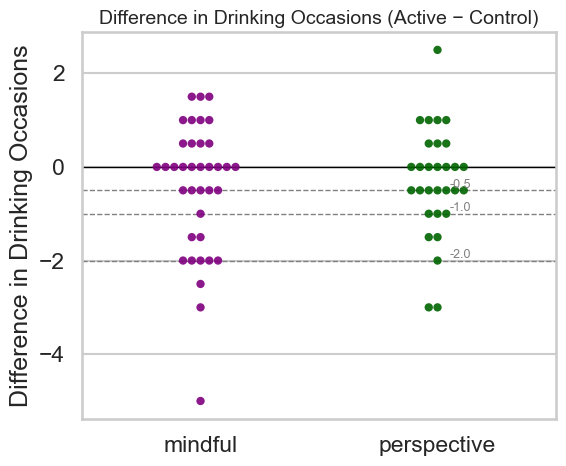

In [24]:
df = pd.read_csv("../data/added_analysis/raw_response.csv")

# Keep only IDs that exist in alc_self
df = df[df['id'].isin(dataframes['alc_self']['id'])]

# Color mapping
palette = {
    'perspective': '#006400',  # dark green
    'mindful': '#800080'       # purple
}

# Plot
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(6, 5))

ax = sns.swarmplot(
    data=df,
    x="condition",
    y="difference_occasions",
    hue="condition",
    palette=palette,
    dodge=False,
    size=6,
    alpha=0.9
)

# Add horizontal lines at thresholds
for thresh in [-0.5, -1.0, -2.0]:
    plt.axhline(y=thresh, color='grey', linestyle='--', linewidth=1)
    plt.text(1.05, thresh+0.05, f'{thresh}', color='grey', fontsize=9)

# Add 0 reference line
plt.axhline(y=0, color='black', linewidth=1)

# Labels
plt.title('Difference in Drinking Occasions (Active − Control)', fontsize=14)
plt.ylabel('Difference in Drinking Occasions')
plt.xlabel('')
plt.legend([], [], frameon=False)  # remove redundant legend since color = x variable

plt.tight_layout()
plt.show()


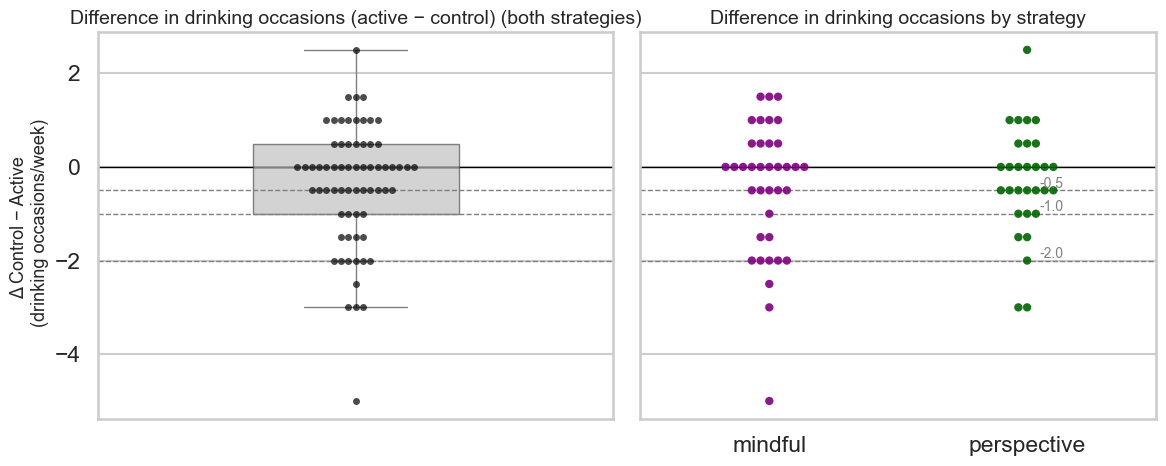

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load and filter data ---
df = pd.read_csv("../data/added_analysis/raw_response.csv")
df = df[df['id'].isin(dataframes['alc_self']['id'])]

# --- Color mapping ---
palette = {
    'perspective': '#006400',  # dark green
    'mindful': '#800080'       # purple
}

# --- Create subplots ---
sns.set(style="whitegrid", context="talk")
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- (1) Pooled box+swarm across both conditions ---
sns.boxplot(
    data=df, y="difference_occasions", ax=axes[0],
    color='lightgray', width=0.4, showfliers=False
)
sns.swarmplot(
    data=df, y="difference_occasions", color='black',
    alpha=0.7, size=5, ax=axes[0]
)
axes[0].axhline(y=0, color='black', linewidth=1)
for thresh in [-0.5, -1.0, -2.0]:
    axes[0].axhline(y=thresh, color='grey', linestyle='--', linewidth=1)
axes[0].set_title('Difference in drinking occasions (active − control) (both strategies)', fontsize=14)
axes[0].set_xlabel('')
axes[0].set_ylabel('Δ Control − Active \n (drinking occasions/week)', fontsize=13)

# --- (2) Per-condition swarm plot ---
sns.swarmplot(
    data=df,
    x="condition",
    y="difference_occasions",
    hue="condition",
    palette=palette,
    dodge=False,
    size=6,
    alpha=0.9,
    ax=axes[1]
)

for thresh in [-0.5, -1.0, -2.0]:
    axes[1].axhline(y=thresh, color='grey', linestyle='--', linewidth=1)
    axes[1].text(1.05, thresh + 0.05, f'{thresh}', color='grey', fontsize=10)

axes[1].axhline(y=0, color='black', linewidth=1)
axes[1].set_title('Difference in drinking occasions by strategy', fontsize=14)
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].legend([], [], frameon=False)

plt.tight_layout()
plt.show()


## Are more adherent people more likely to respond?

Mann–Whitney U = 368.50, p = 0.749


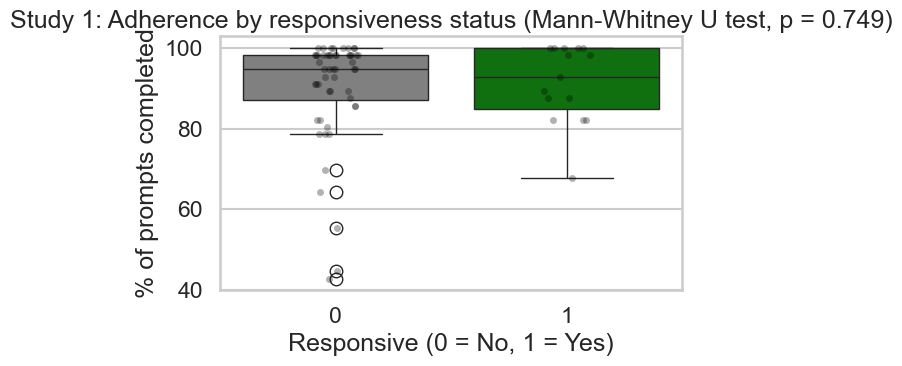

                  min    max  median    std  count
responsive                                        
Non-responders  42.86  100.0   94.64  13.42     52
Responders      67.86  100.0   92.86   9.67     15


In [26]:
# Load data
df_main = pd.read_csv("../data/intervention_time/responsiveness_study1.csv")
df_adherence_1 = pd.read_csv("../data/intervention_time/osf_study1.csv")[['id', 'alc_responses']].drop_duplicates('id')

# Merge on id
merged_df = df_main.merge(df_adherence_1, on='id', how='inner')

# Drop rows with missing adherence values (if any)
merged_df = merged_df.dropna(subset=['alc_responses'])
merged_df['alc_responses'] = (merged_df['alc_responses'] / 56) * 100
merged_df = merged_df[merged_df['id'].isin(dataframes['alc_self']['id'])]

# --- Stats test ---
from scipy.stats import mannwhitneyu

# Split by responsiveness
group0 = merged_df.loc[merged_df['responsive'] == 0, 'alc_responses']
group1 = merged_df.loc[merged_df['responsive'] == 1, 'alc_responses']

# Mann–Whitney U test (two-sided)
stat, pval = mannwhitneyu(group0, group1, alternative='two-sided')
print(f"Mann–Whitney U = {stat:.2f}, p = {pval:.3f}")

# --- Boxplot ---
plt.figure(figsize=(6, 4))
sns.boxplot(data=merged_df, x='responsive', y='alc_responses', palette=['gray', 'green'])
sns.stripplot(data=merged_df, x='responsive', y='alc_responses', color='black', alpha=0.3)
plt.xlabel('Responsive (0 = No, 1 = Yes)')
plt.ylabel('% of prompts completed')
plt.title(f'Study 1: Adherence by responsiveness status (Mann-Whitney U test, p = {pval:.3f})')
plt.tight_layout()
plt.show()

summary = (
    merged_df.groupby('responsive')['alc_responses']
    .agg(['min', 'max', 'median', 'std', 'count'])
    .rename(index={0: 'Non-responders', 1: 'Responders'})
    .round(2)
)

print(summary)


In [27]:
overall = merged_df['alc_responses']

overall_stats = pd.Series({
    'mean': overall.mean(),
    'std': overall.std(),
    'min': overall.min(),
    'max': overall.max(),
    'median': overall.median(),
    'count': overall.count()
}).round(2)

print("=== Overall adherence (all participants) ===")
print(overall_stats)

=== Overall adherence (all participants) ===
mean       90.25
std        12.62
min        42.86
max       100.00
median     94.64
count      67.00
dtype: float64


Mann–Whitney U = 1242.00, p = 0.876


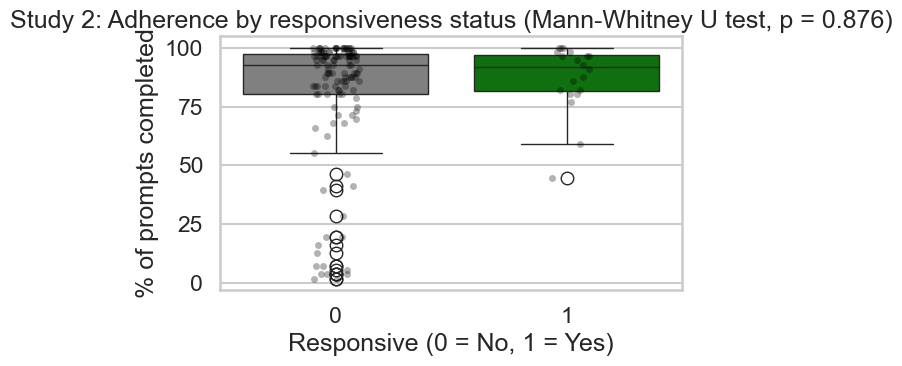

                  min    max  median    std  count
responsive                                        
Non-responders   1.79  100.0   92.86  26.94    127
Responders      44.64  100.0   91.96  14.43     20


In [28]:
# Load data
df_main = pd.read_csv("../data/intervention_time/responsiveness_study2.csv")
df_adherence_2 = pd.read_csv("../data/intervention_time/osf_study2.csv")[['id', 'alc_responses']].drop_duplicates('id')

# Merge on id
merged_df = df_main.merge(df_adherence_2, on='id', how='inner')

# Drop rows with missing adherence values (if any)
merged_df = merged_df.dropna(subset=['alc_responses'])
# Convert raw counts to percentage of prompts completed
merged_df['alc_responses'] = (merged_df['alc_responses'] / 56) * 100
merged_df = merged_df[merged_df['id'].isin(responsive_study2['id'])]

# --- Stats test ---
from scipy.stats import mannwhitneyu

# Split by responsiveness
group0 = merged_df.loc[merged_df['responsive'] == 0, 'alc_responses']
group1 = merged_df.loc[merged_df['responsive'] == 1, 'alc_responses']

# Mann–Whitney U test (two-sided)
stat, pval = mannwhitneyu(group0, group1, alternative='two-sided')
print(f"Mann–Whitney U = {stat:.2f}, p = {pval:.3f}")

# --- Boxplot ---
plt.figure(figsize=(6, 4))
sns.boxplot(data=merged_df, x='responsive', y='alc_responses', palette=['gray', 'green'])
sns.stripplot(data=merged_df, x='responsive', y='alc_responses', color='black', alpha=0.3)
plt.xlabel('Responsive (0 = No, 1 = Yes)')
plt.ylabel('% of prompts completed')
plt.title(f'Study 2: Adherence by responsiveness status (Mann-Whitney U test, p = {pval:.3f})')
plt.tight_layout()
plt.show()

summary = (
    merged_df.groupby('responsive')['alc_responses']
    .agg(['min', 'max', 'median', 'std', 'count'])
    .rename(index={0: 'Non-responders', 1: 'Responders'})
    .round(2)
)

print(summary)


In [29]:
overall = merged_df['alc_responses']

overall_stats = pd.Series({
    'mean': overall.mean(),
    'std': overall.std(),
    'min': overall.min(),
    'max': overall.max(),
    'median': overall.median(),
    'count': overall.count()
}).round(2)

print("=== Overall adherence (all participants) ===")
print(overall_stats)

=== Overall adherence (all participants) ===
mean       82.07
std        25.64
min         1.79
max       100.00
median     92.86
count     147.00
dtype: float64


## Are there demographic differences between responders and non-responders?


In [30]:
# Step 1: Get common IDs
common_ids = set.intersection(*[set(df['id']) for df in dataframes.values()])

# Step 2: Filter demographics
demo_filtered = dataframes['demo'][dataframes['demo']['id'].isin(common_ids)]

# Step 3: Compute summaries
N = demo_filtered.shape[0]
age_mean = round(demo_filtered['age'].mean(), 2)
age_sd = round(demo_filtered['age'].std(), 2)

# Gender distribution
gender_counts = demo_filtered['gender_numeric'].value_counts().sort_index()
gender_percent = round(100 * gender_counts / gender_counts.sum(), 1)

# Step 4: Print results
print(f"N = {N}")
# Step 2: Age stats
age_mean = demo_filtered['age'].mean()
age_sd =demo_filtered['age'].std()
age_min = demo_filtered['age'].min()
age_max = demo_filtered['age'].max()
print(f"Age: M = {round(age_mean, 2)}, SD = {round(age_sd, 2)}, Min = {age_min}, Max = {age_max}")
print("Gender distribution:")
for gender, count in gender_counts.items():
    percent = gender_percent[gender]
    print(f"  Gender {gender}: {count} ({percent}%)")

# Number of responsive participants
num_responsive = demo_filtered['responsive'].sum()
print(f"Responsive participants: {num_responsive} out of {N} ({round(100 * num_responsive / N, 1)}%)")

# Income distribution
income_median = demo_filtered['income_numeric'].median()
income_mean = round(demo_filtered['income_numeric'].mean(), 2)
income_sd = round(demo_filtered['income_numeric'].std(), 2)
print(f"Income: Median = {income_median}, Mean = {income_mean}, SD = {income_sd}")
income_min = demo_filtered['income_numeric'].min()
income_max = demo_filtered['income_numeric'].max()
income_median = demo_filtered['income_numeric'].median()
print(f"The household income for Study 1 participants was between {income_min} and {income_max}, with a median of {income_median}.")


# Race distribution (including missing)
race_counts = demo_filtered['race_numeric'].value_counts(dropna=False).sort_index()
race_percent = round(100 * race_counts / race_counts.sum(), 1)
print("Race distribution:")
for race, count in race_counts.items():
    label = "Missing" if pd.isna(race) else f"Race {race}"
    percent = race_percent[race]
    print(f"  {label}: {count} ({percent}%)")

# College year distribution (categorical)
college_counts = demo_filtered['college_year'].value_counts().sort_index()
college_percent = round(100 * college_counts / college_counts.sum(), 1)
print("College year distribution:")
for year, count in college_counts.items():
    label = "Missing" if pd.isna(year) else f"Year {year}"
    percent = college_percent[year]
    print(f"  {label}: {count} ({percent}%)")

N = 67
Age: M = 20.48, SD = 1.76, Min = 18, Max = 28
Gender distribution:
  Gender 1: 26 (38.8%)
  Gender 2: 41 (61.2%)
Responsive participants: 15 out of 67 (22.4%)
Income: Median = 149999.5, Mean = 133225.48, SD = 63228.54
The household income for Study 1 participants was between 4999.5 and 200000.0, with a median of 149999.5.
Race distribution:
  Race 1: 37 (55.2%)
  Race 2: 21 (31.3%)
  Race 3: 2 (3.0%)
  Race 4: 2 (3.0%)
  Race 5: 5 (7.5%)
College year distribution:
  Year 1: 18 (26.9%)
  Year 2: 12 (17.9%)
  Year 3: 19 (28.4%)
  Year 4: 16 (23.9%)
  Year 5: 2 (3.0%)


In [31]:
groups = {
    "Responsive": demo_filtered[demo_filtered['responsive'] == 1],
    "Non-responsive": demo_filtered[demo_filtered['responsive'] == 0]
}

for name, df in groups.items():
    print(f"\n===== {name} participants =====")
    N = df.shape[0]
    print(f"N = {N}")

    # Age
    age_mean = df['age'].mean()
    age_sd = df['age'].std()
    age_min = df['age'].min()
    age_max = df['age'].max()
    print(f"Age: M = {round(age_mean, 2)}, SD = {round(age_sd, 2)}, Min = {age_min}, Max = {age_max}")

    # Gender
    gender_counts = df['gender_numeric'].value_counts().sort_index()
    gender_percent = round(100 * gender_counts / gender_counts.sum(), 1)
    print("Gender distribution:")
    for gender, count in gender_counts.items():
        percent = gender_percent[gender]
        print(f"  Gender {gender}: {count} ({percent}%)")

    # Income
    income_mean = df['income_numeric'].mean()
    income_sd = df['income_numeric'].std()
    income_min = df['income_numeric'].min()
    income_max = df['income_numeric'].max()
    income_median = df['income_numeric'].median()
    print(f"Income: Median = {income_median}, Mean = {round(income_mean, 2)}, SD = {round(income_sd, 2)}, "
          f"Range = [{income_min}, {income_max}]")

    # Race
    race_counts = df['race_numeric'].value_counts(dropna=False).sort_index()
    race_percent = round(100 * race_counts / race_counts.sum(), 1)
    print("Race distribution:")
    for race, count in race_counts.items():
        label = "Missing" if pd.isna(race) else f"Race {race}"
        percent = race_percent[race]
        print(f"  {label}: {count} ({percent}%)")

    # College year
    college_counts = df['college_year'].value_counts().sort_index()
    college_percent = round(100 * college_counts / college_counts.sum(), 1)
    print("College year distribution:")
    for year, count in college_counts.items():
        label = "Missing" if pd.isna(year) else f"Year {year}"
        percent = college_percent[year]
        print(f"  {label}: {count} ({percent}%)")



===== Responsive participants =====
N = 15
Age: M = 20.53, SD = 1.55, Min = 18, Max = 23
Gender distribution:
  Gender 1: 8 (53.3%)
  Gender 2: 7 (46.7%)
Income: Median = 149999.5, Mean = 138035.39, SD = 66846.58, Range = [4999.5, 200000.0]
Race distribution:
  Race 1: 11 (73.3%)
  Race 2: 1 (6.7%)
  Race 3: 1 (6.7%)
  Race 5: 2 (13.3%)
College year distribution:
  Year 1: 4 (26.7%)
  Year 2: 1 (6.7%)
  Year 3: 3 (20.0%)
  Year 4: 6 (40.0%)
  Year 5: 1 (6.7%)

===== Non-responsive participants =====
N = 52
Age: M = 20.46, SD = 1.83, Min = 18, Max = 28
Gender distribution:
  Gender 1: 18 (34.6%)
  Gender 2: 34 (65.4%)
Income: Median = 149999.5, Mean = 131822.58, SD = 62799.98, Range = [12499.5, 200000.0]
Race distribution:
  Race 1: 26 (50.0%)
  Race 2: 20 (38.5%)
  Race 3: 1 (1.9%)
  Race 4: 2 (3.8%)
  Race 5: 3 (5.8%)
College year distribution:
  Year 1: 14 (26.9%)
  Year 2: 11 (21.2%)
  Year 3: 16 (30.8%)
  Year 4: 10 (19.2%)
  Year 5: 1 (1.9%)


### Baseline drinking levels

In [32]:
b1_alcohol_self_response

,id,alc_binge_efficacy,alc_intent_binge,DMQ_drinking_coping_motive,DMQ_drinking_enhancement_motive,DMQ_drinking_social_motive,DMQ_drinking_conformity_motive,AUQ_drink_intent,AUQ_drink_frequency,AUQ_drink_amount,alcohol_alc_att_1,alcohol_alc_att_2,DEQ_reduced_tension_exp,DEQ_increased_confidence_exp,DEQ_negative_consequences_exp,DEQ_reduced_cognition_exp,DEQ_increased_sexual_exp,responsive
0,muri012,2,1,1.2,1.6,3.4,2.4,0,1,3.5,5.8,4.4,NaN,NaN,NaN,NaN,NaN,0
1,muri017,1,1,1.0,1.0,1.2,1.4,0,0,1.0,3.6,4.8,1.75,2.333333,2.500000,3.0,2.0,0
2,muri034,1,2,1.2,2.2,3.6,1.4,0,2,3.0,5.2,4.0,2.50,4.166667,2.000000,3.0,5.0,1
3,muri041,1,2,2.2,1.4,4.4,2.4,2,1,3.0,5.0,4.2,3.00,4.166667,1.833333,2.0,3.0,0
4,muri063,3,3,2.2,4.0,4.0,2.2,0,1,5.0,5.4,4.8,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,muric430,2,4,1.8,4.2,4.4,1.8,3,0,0.0,4.8,3.8,3.50,5.000000,2.666667,3.0,5.0,0
65,muric431,3,2,2.4,3.6,4.6,1.2,3,1,2.0,6.2,4.8,1.75,4.500000,1.833333,3.5,4.0,0
66,muric432,3,2,2.6,3.8,4.0,1.8,3,0,0.0,5.2,5.0,3.50,4.166667,2.333333,3.5,4.0,1
67,muric434,1,1,1.0,1.2,1.2,1.0,1,1,0.5,5.0,5.0,1.75,2.333333,2.166667,2.0,2.0,0


In [33]:
from scipy.stats import ttest_ind

baseline_alc_self = baseline_demo_all[
    baseline_demo_all['pID'].isin(demo_filtered['id'])
]

baseline_alc_self = baseline_alc_self.merge(b1_alcohol_self_response, left_on='pID', right_on='id', how='inner')

# Pool responders + non-responders
baseline_intervention = baseline_alc_self[
    baseline_alc_self['responsive'].isin([0, 1])
]

# Clean invalid values
baseline_intervention = baseline_intervention[
    (baseline_intervention['freq_self'] >= 0) &
    (baseline_intervention['amount_self'] >= 0)
]
control_unique = (
    data_study2_control[['id', 'alc_responses']]
    .drop_duplicates('id')
    .copy()
)

control_ids = control_unique[['id']].drop_duplicates('id')

# Baseline rows for controls
baseline_controls = baseline_demo_all[
    baseline_demo_all['pID'].isin(control_ids['id'])
].copy()

baseline_controls = baseline_controls[
    (baseline_controls['freq_self'] >= 0) &
    (baseline_controls['amount_self'] >= 0)
]

# Extract numeric series
ctrl_freq = baseline_controls['freq_self'].dropna()
int_freq = baseline_intervention['freq_self'].dropna()

ctrl_amount = baseline_controls['amount_self'].dropna()
int_amount = baseline_intervention['amount_self'].dropna()

# Welch t-tests (unequal variances)
t_freq, p_t_freq = ttest_ind(ctrl_freq, int_freq, equal_var=False)
t_amount, p_t_amount = ttest_ind(ctrl_amount, int_amount, equal_var=False)

print("=== Welch t-test: Control vs Intervention (pooled) ===")
print(f"freq_self: t = {t_freq:.2f}, p = {p_t_freq:.3f}")
print(f"amount_self: t = {t_amount:.2f}, p = {p_t_amount:.3f}")


=== Welch t-test: Control vs Intervention (pooled) ===
freq_self: t = 2.83, p = 0.006
amount_self: t = -0.47, p = 0.642


In [34]:
from scipy.stats import ttest_ind, mannwhitneyu

# 1. Filter AUQ dataframe to only IDs present in demo
auq_filtered = b1_alcohol_self_response[
    b1_alcohol_self_response['id'].isin(demo_filtered['id'])
].copy()

# 2. Split by responder status
responders = auq_filtered[auq_filtered['responsive'] == 1].copy()
non_responders = auq_filtered[auq_filtered['responsive'] == 0].copy()

# 3. Ensure numeric
cols = ['AUQ_drink_frequency', 'AUQ_drink_amount']
for c in cols:
    responders[c] = pd.to_numeric(responders[c], errors='coerce')
    non_responders[c] = pd.to_numeric(non_responders[c], errors='coerce')

# 4. Run tests
for col in cols:
    x = responders[col].dropna()
    y = non_responders[col].dropna()
    
    print(f"\n=== {col} ===")
    print("n_responder:", len(x), "n_nonresp:", len(y))

    # Welch t-test (unequal variances)
    t_stat, p_t = ttest_ind(x, y, equal_var=False)
    print(f"Welch t-test: t = {t_stat:.2f}, p = {p_t:.3f}")

    # Mann-Whitney U
    u_stat, p_u = mannwhitneyu(x, y, alternative="two-sided")
    print(f"Mann-Whitney U: U = {u_stat:.2f}, p = {p_u:.3f}")



=== AUQ_drink_frequency ===
n_responder: 15 n_nonresp: 52
Welch t-test: t = 2.43, p = 0.022
Mann-Whitney U: U = 547.50, p = 0.013

=== AUQ_drink_amount ===
n_responder: 15 n_nonresp: 52
Welch t-test: t = 0.63, p = 0.531
Mann-Whitney U: U = 464.50, p = 0.259


In [35]:
!pip3 install --upgrade scipy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


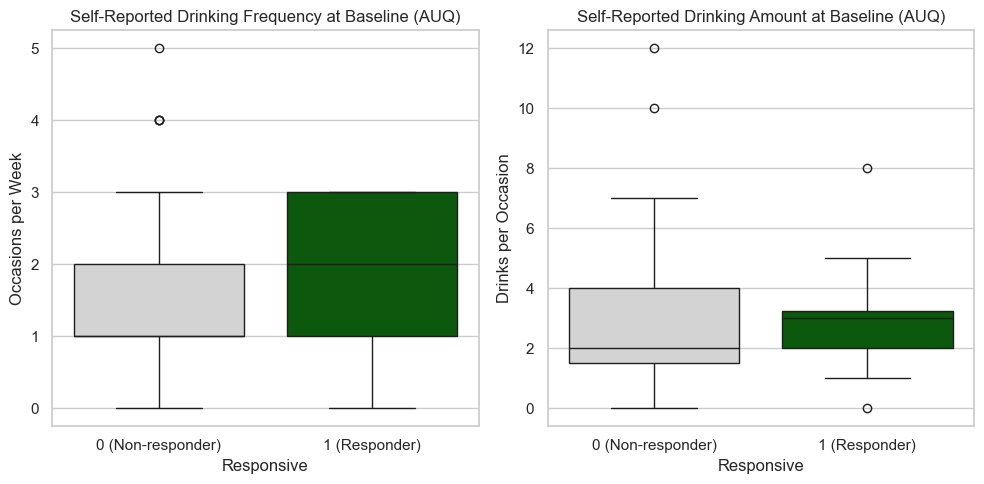

AUQ_drink_frequency: t = 2.43, p = 0.022
AUQ_drink_amount: t = 0.63, p = 0.531


In [36]:

palette = {'0': 'lightgray', '1': 'darkgreen'}

sns.set(style='whitegrid')

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)

# --- Frequency (occasions/week) ---
sns.boxplot(
    data=b1_alcohol_self_response,
    x='responsive', y='AUQ_drink_frequency',
    ax=axes[0], palette=palette
)
axes[0].set_title('Self-Reported Drinking Frequency at Baseline (AUQ)')
axes[0].set_xlabel('Responsive')
axes[0].set_ylabel('Occasions per Week')
axes[0].set_xticklabels(['0 (Non-responder)', '1 (Responder)'])

# --- Amount (drinks per occasion) ---
sns.boxplot(
    data=b1_alcohol_self_response,
    x='responsive', y='AUQ_drink_amount',
    ax=axes[1], palette=palette
)
axes[1].set_title('Self-Reported Drinking Amount at Baseline (AUQ)')
axes[1].set_xlabel('Responsive')
axes[1].set_ylabel('Drinks per Occasion')
axes[1].set_xticklabels(['0 (Non-responder)', '1 (Responder)'])

plt.tight_layout()
plt.show()

from scipy.stats import ttest_ind

# Define numeric columns
cols = ['AUQ_drink_frequency', 'AUQ_drink_amount']

# Run t-tests
for col in cols:
    t_stat, p_val = ttest_ind(
        responders[col].dropna(),
        non_responders[col].dropna(),
        equal_var=False  # Welch’s t-test (robust to unequal variances)
    )
    print(f"{col}: t = {t_stat:.2f}, p = {p_val:.3f}")


In [37]:

cols = ['AUQ_drink_frequency', 'AUQ_drink_amount']

for col in cols:
    x = responders[col].dropna().values
    y = non_responders[col].dropna().values

    # Welch t-test
    t_stat, p_val = ttest_ind(x, y, equal_var=False)

    n1, n2 = len(x), len(y)
    v1, v2 = np.var(x, ddof=1), np.var(y, ddof=1)

    df = (v1/n1 + v2/n2)**2 / (
        (v1**2) / ((n1**2) * (n1 - 1)) +
        (v2**2) / ((n2**2) * (n2 - 1))
    )

    print(f"{col}: t({df:.2f}) = {t_stat:.2f}, p = {p_val:.3f}")

AUQ_drink_frequency: t(26.81) = 2.43, p = 0.022
AUQ_drink_amount: t(26.99) = 0.63, p = 0.531


### Average drinking on on/off weeks

In [38]:
### 

study_1_response= data_study1.merge(demo_filtered, on='id', how='left')
study_1_response = study_1_response[study_1_response['id'].isin(demo_filtered['id'])]

# Convert drinks_number to numeric just in case
data_study1['drinks_number'] = pd.to_numeric(data_study1['drinks_number'], errors='coerce')

# Aggregate per participant and week type
weekly_stats = (
    data_study1
    .groupby(['id', 'active_week'])
    .agg(
        total_drinks=('drinks_number', 'sum'),
        occasions_number=('drinks_number', lambda x: (x > 0).sum())
    )
    .reset_index()
)

summary = (
    weekly_stats
    .pivot(index='id', columns='active_week', values=['total_drinks', 'occasions_number'])
    .fillna(0)
)

# Flatten the column names
summary.columns = [f"{col[0]}_{col[1]}" for col in summary.columns]
summary = summary.reset_index()

summary['avg_drinks_active'] = summary['total_drinks_active'] / summary['occasions_number_active'] 
summary['avg_drinks_control'] = summary['total_drinks_control'] / summary['occasions_number_control']
summary['avg_occasions_active'] = summary['occasions_number_active'] / 2
summary['avg_occasions_control'] = summary['occasions_number_control'] / 2



In [39]:
merged_final = summary.merge(
    responsive_study1[['id', 'responsive']],
    on='id',
    how='inner'
)

In [40]:
merged_final.dropna(inplace=True)

In [41]:
merged_final = merged_final[merged_final['id'].isin(demo_filtered['id'])]
merged_final

,id,total_drinks_active,total_drinks_control,occasions_number_active,occasions_number_control,avg_drinks_active,avg_drinks_control,avg_occasions_active,avg_occasions_control,responsive
0,muri012,1.0,2.0,1.0,1.0,1.000000,2.000000,0.5,0.5,0
2,muri034,5.0,15.0,4.0,7.0,1.250000,2.142857,2.0,3.5,1
3,muri041,2.0,15.0,2.0,2.0,1.000000,7.500000,1.0,1.0,0
4,muri063,3.0,14.0,2.0,5.0,1.500000,2.800000,1.0,2.5,1
5,muri078,23.0,34.0,7.0,10.0,3.285714,3.400000,3.5,5.0,1
9,muri092,54.0,65.0,10.0,11.0,5.400000,5.909091,5.0,5.5,0
10,muri096,5.0,2.0,4.0,2.0,1.250000,1.000000,2.0,1.0,0
11,muri098,9.0,6.0,4.0,3.0,2.250000,2.000000,2.0,1.5,0
13,muri101,4.0,13.0,2.0,6.0,2.000000,2.166667,1.0,3.0,1
14,muri117,12.0,8.0,4.0,2.0,3.000000,4.000000,2.0,1.0,0


In [42]:
# Compute summary stats for responders and non-responders
stats = (
    merged_final
    .groupby('responsive')[[
        'avg_drinks_control', 'avg_drinks_active',
        'avg_occasions_control', 'avg_occasions_active'
    ]]
    .agg(['mean', 'median', 'std', 'min', 'max'])
    .round(2)
)

# Flatten multi-level columns for readability
stats.columns = [f"{col[0]}_{col[1]}" for col in stats.columns]
stats = stats.reset_index()


stats

,responsive,avg_drinks_control_mean,avg_drinks_control_median,avg_drinks_control_std,avg_drinks_control_min,avg_drinks_control_max,avg_drinks_active_mean,avg_drinks_active_median,avg_drinks_active_std,avg_drinks_active_min,...,avg_occasions_control_mean,avg_occasions_control_median,avg_occasions_control_std,avg_occasions_control_min,avg_occasions_control_max,avg_occasions_active_mean,avg_occasions_active_median,avg_occasions_active_std,avg_occasions_active_min,avg_occasions_active_max
0,0,3.13,2.73,1.79,1.0,7.50,3.07,2.73,1.82,1.0,...,1.68,1.5,1.15,0.5,5.5,1.87,1.5,1.13,0.5,5.0
1,1,2.95,2.80,0.98,1.5,4.83,2.14,2.00,0.90,1.0,...,4.00,3.0,1.93,2.5,9.5,1.73,1.0,1.32,0.5,4.5


In [43]:
study_1_response

,Unnamed: 0,drinks_number,active_week,condition,signal_count,alc_responses,social_weekend,group,id,college_year,age,gender_numeric,race_numeric,income_numeric,responsive
0,1,0.0,control,mindful,1,53,Weekend,g2p,muri012,1.0,19.0,1.0,1.0,87499.5,0.0
1,2,0.0,active,mindful,2,53,Weekend,g2p,muri012,1.0,19.0,1.0,1.0,87499.5,0.0
2,3,0.0,active,mindful,3,53,Weekend,g2p,muri012,1.0,19.0,1.0,1.0,87499.5,0.0
3,4,0.0,active,mindful,4,53,Week,g2p,muri012,1.0,19.0,1.0,1.0,87499.5,0.0
4,5,0.0,active,mindful,5,53,Week,g2p,muri012,1.0,19.0,1.0,1.0,87499.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5987,5988,0.0,active,perspective,52,51,Week,g6c,muric435,4.0,22.0,2.0,1.0,200000.0,0.0
5988,5989,0.0,active,perspective,53,51,Week,g6c,muric435,4.0,22.0,2.0,1.0,200000.0,0.0
5989,5990,0.0,active,perspective,54,51,Week,g6c,muric435,4.0,22.0,2.0,1.0,200000.0,0.0
5990,5991,0.0,active,perspective,55,51,Week,g6c,muric435,4.0,22.0,2.0,1.0,200000.0,0.0


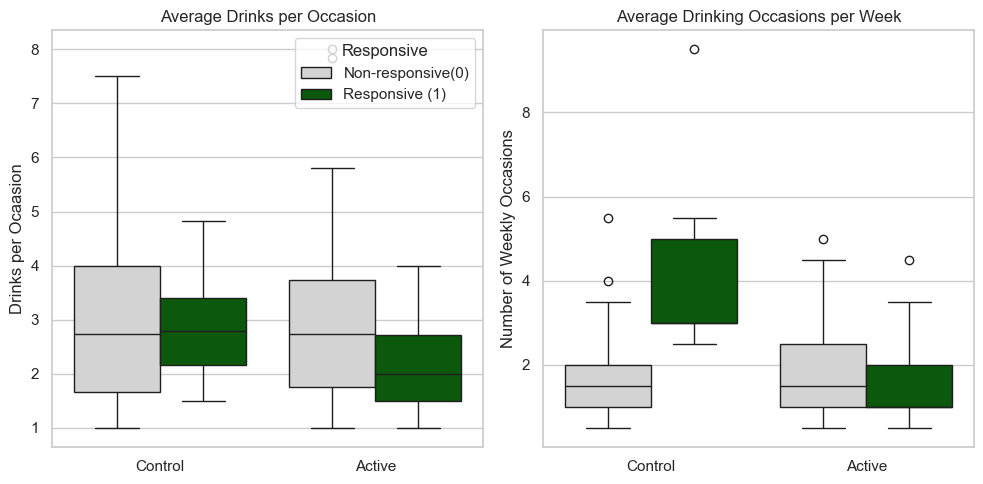

                                 Measure  Responsive Mean  \
0          Control – Drinks per Occasion            2.949   
1           Active – Drinks per Occasion            2.143   
2  Control – Drinking Occasions per Week            4.000   
3   Active – Drinking Occasions per Week            1.731   

   Non-responsive Mean      t      p  
0                3.131 -0.455  0.652  
1                3.067 -2.392  0.021  
2                1.684  4.092  0.001  
3                1.868 -0.337  0.740  


In [44]:
plot_df = merged_final.melt(
    id_vars='responsive',
    value_vars=[
        'avg_drinks_control', 'avg_drinks_active',
        'avg_occasions_control', 'avg_occasions_active'
    ],
    var_name='measure',
    value_name='value'
)

# Add helper columns
plot_df['type'] = plot_df['measure'].apply(lambda x: 'Drinks' if 'drinks' in x else 'Occasions')
plot_df['condition'] = plot_df['measure'].apply(lambda x: 'Active' if 'active' in x else 'Control')

# Define colors
palette = {0: 'lightgray', 1: 'darkgreen'}

# Set up plotting
sns.set(style='whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)

# --- Drinks plot ---
sns.boxplot(
    data=plot_df[plot_df['type'] == 'Drinks'],
    x='condition', y='value', hue='responsive',
    ax=axes[0], palette=palette
)
axes[0].set_title('Average Drinks per Occasion')
axes[0].set_xlabel('')
axes[0].set_ylabel('Drinks per Ocaasion')

# Manually fix legend colors
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(
    handles, ['Non-responsive(0)', 'Responsive (1)'],
    title='Responsive',
    facecolor='white',
    frameon=True
)

# --- Occasions plot ---
sns.boxplot(
    data=plot_df[plot_df['type'] == 'Occasions'],
    x='condition', y='value', hue='responsive',
    ax=axes[1], palette=palette
)
axes[1].set_title('Average Drinking Occasions per Week')
axes[1].set_xlabel('')
axes[1].set_ylabel('Number of Weekly Occasions')
axes[1].legend().remove()

plt.tight_layout()
plt.show()

tests = [
    ('avg_drinks_control', 'Control – Drinks per Occasion'),
    ('avg_drinks_active', 'Active – Drinks per Occasion'),
    ('avg_occasions_control', 'Control – Drinking Occasions per Week'),
    ('avg_occasions_active', 'Active – Drinking Occasions per Week')
]

results = []

for var, label in tests:
    # Extract responder groups
    res_vals = merged_final.loc[merged_final['responsive'] == 1, var].dropna()
    nonres_vals = merged_final.loc[merged_final['responsive'] == 0, var].dropna()

    # Welch’s t-test (unequal variances)
    t_stat, p_val = ttest_ind(res_vals, nonres_vals, equal_var=False)

    results.append({
        "Measure": label,
        "Responsive Mean": res_vals.mean(),
        "Non-responsive Mean": nonres_vals.mean(),
        "t": t_stat,
        "p": p_val
    })

# Create summary table
test_df = pd.DataFrame(results).round(3)
print(test_df)

### Characteristics of Mindful vs Perspective

In [45]:
mindful_ids_study1 = study_1_response.loc[study_1_response["condition"] == "mindful", "id"].unique()
perspective_ids_study1 = study_1_response.loc[study_1_response["condition"] == "perspective", "id"].unique()

print("Mindful IDs:", len(mindful_ids_study1))
print("Perspective IDs:", len(perspective_ids_study1))

Mindful IDs: 37
Perspective IDs: 30


In [46]:
df_adherence_1

,id,alc_responses
0,muri012,53
56,muri017,51
112,muri034,46
168,muri041,55
224,muri061,55
...,...,...
5768,muric431,49
5824,muric432,56
5880,muric434,53
5936,muric435,51


In [47]:
## Adherence by intervention type
cond_map = study_1_response[['id', 'condition']].drop_duplicates('id')

# --- Merge condition with adherence ---
merged_df = df_adherence_1.merge(cond_map, on='id', how='inner')

# --- Check ---
print(merged_df['condition'].value_counts(dropna=False))

# --- Compute adherence stats per condition ---
adherence_stats = (
    merged_df
    .groupby('condition')['alc_responses']
    .agg(['mean', 'std', 'min', 'max'])
    .round(2)
)

print(adherence_stats/56)


condition
mindful        37
perspective    30
Name: count, dtype: int64
                 mean       std       min  max
condition                                     
mindful      0.905893  0.117500  0.553571  1.0
perspective  0.898214  0.138036  0.428571  1.0


## Sample Characteristics Study 2

In [48]:
# Study 2
# Step 1: Merge on 'id' (left join)
merged = pd.merge(b2_group_subjective_test, baseline_demo_study2, on='id', how='left')
print(len(merged))

merged.columns
# Step 2: Age stats
age_mean = merged['age'].mean()
age_sd = merged['age'].std()

# Step 3: Gender distribution
gender_counts = merged['gender_numeric'].value_counts().sort_index()
gender_percent = round(100 * gender_counts / gender_counts.sum(), 1)

# Step 4: Responsive distribution
responsive_counts = merged['responsive'].value_counts().sort_index()
responsive_percent = round(100 * responsive_counts / responsive_counts.sum(), 1)

# Output
age_min = merged['age'].min()
age_max = merged['age'].max()
print(f"Age: M = {round(age_mean, 2)}, SD = {round(age_sd, 2)}, Min = {age_min}, Max = {age_max}")
# Gender distribution (including missing)
gender_counts = merged['gender_numeric'].value_counts(dropna=False).sort_index()
gender_percent = round(100 * gender_counts / gender_counts.sum(), 1)
print("Gender distribution:")
for gender, count in gender_counts.items():
    label = "Missing" if pd.isna(gender) else f"Gender {gender}"
    percent = gender_percent[gender]
    print(f"  {label}: {count} ({percent}%)")

# Responsive distribution (including missing)
responsive_counts = merged['responsive'].value_counts(dropna=False).sort_index()
responsive_percent = round(100 * responsive_counts / responsive_counts.sum(), 1)
print("Responsive distribution:")
for resp, count in responsive_counts.items():
    label = "Missing" if pd.isna(resp) else f"Responsive = {resp}"
    percent = responsive_percent[resp]
    print(f"  {label}: {count} ({percent}%)")

# Race distribution (including missing)
race_counts = merged['race_numeric'].value_counts(dropna=False).sort_index()
race_percent = round(100 * race_counts / race_counts.sum(), 1)
print("Race distribution:")
for race, count in race_counts.items():
    label = "Missing" if pd.isna(race) else f"Race {race}"
    percent = race_percent[race]
    print(f"  {label}: {count} ({percent}%)")

# College year distribution (including missing)
college_counts = merged['college_year'].value_counts(dropna=False).sort_index()
college_percent = round(100 * college_counts / college_counts.sum(), 1)
print("College year distribution:")
for year, count in college_counts.items():
    label = "Missing" if pd.isna(year) else f"Year {year}"
    percent = college_percent[year]
    print(f"  {label}: {count} ({percent}%)")

# Income distribution
income_median = merged['income_numeric'].median()
income_mean = round(merged['income_numeric'].mean(), 2)
income_sd = round(merged['income_numeric'].std(), 2)
print(f"Income: Median = {income_median}, Mean = {income_mean}, SD = {income_sd}")
income_min = merged['income_numeric'].min()
income_max = merged['income_numeric'].max()
income_median = merged['income_numeric'].median()
print(f"The household income for Study 1 participants was between {income_min} and {income_max}, with a median of {income_median}.")

merged["id"].to_csv("../data/study_2_ids.csv")


114
Age: M = 20.15, SD = 1.26, Min = 18.0, Max = 25.0
Gender distribution:
  Gender 1.0: 23 (20.2%)
  Gender 2.0: 91 (79.8%)
Responsive distribution:
  Responsive = 0: 100 (87.7%)
  Responsive = 1: 14 (12.3%)
Race distribution:
  Race Asian: 40 (35.1%)
  Race Black or African American: 12 (10.5%)
  Race Black or African American,Asian: 1 (0.9%)
  Race Latino/a: 6 (5.3%)
  Race Other: 2 (1.8%)
  Race White: 44 (38.6%)
  Race White,American Indian or Alaska Native: 1 (0.9%)
  Race White,American Indian or Alaska Native,Latino/a: 1 (0.9%)
  Race White,Asian: 2 (1.8%)
  Race White,Latino/a: 2 (1.8%)
  Race White,Native Hawaiian or Other Pacific Islander: 1 (0.9%)
  Missing: 2 (1.8%)
College year distribution:
  Year 1.0: 19 (16.7%)
  Year 2.0: 31 (27.2%)
  Year 3.0: 29 (25.4%)
  Year 4.0: 31 (27.2%)
  Year 5.0: 2 (1.8%)
  Missing: 2 (1.8%)
Income: Median = 15.0, Mean = 13.5, SD = 6.73
The household income for Study 1 participants was between 0.0 and 20.0, with a median of 15.0.


In [49]:
# # === Study 2 controls descriptives ===

# # Step 0: unique control IDs
# control_ids = data_study2_control[['id']].drop_duplicates('id')

# # Step 1: Merge unique control IDs with baseline demographics
# merged_control = pd.merge(control_ids, baseline_demo_all, left_on='id', right_on='pID', how='left')
# print("N unique Study 2 control IDs:", merged_control['id'].nunique())
# print("N rows in merged control demo df:", len(merged_control))

# # Step 2: Age stats
# age_mean = merged_control['age'].mean()
# age_sd = merged_control['age'].std()
# age_min = merged_control['age'].min()
# age_max = merged_control['age'].max()
# print(f"Age (controls): M = {round(age_mean, 2)}, SD = {round(age_sd, 2)}, Min = {age_min}, Max = {age_max}")

# # Step 3: Gender distribution (including missing)
# gender_counts = merged_control['gender_numeric'].value_counts(dropna=False)
# gender_percent = round(100 * gender_counts / gender_counts.sum(), 1)
# print("Gender distribution (controls):")
# for gender, count in gender_counts.items():
#     label = "Missing" if pd.isna(gender) else str(gender)
#     percent = gender_percent[gender]
#     print(f"  {label}: {count} ({percent}%)")

# # Step 4: Race distribution (categorical)
# race_counts = merged_control['race'].value_counts(dropna=False)
# race_percent = round(100 * race_counts / race_counts.sum(), 1)

# print("Race distribution (controls):")
# for race_value, count in race_counts.items():
#     label = "Missing" if pd.isna(race_value) else str(race_value)
#     percent = race_percent[race_value]
#     print(f"  {label}: {count} ({percent}%)")

# # Step 5: Income distribution (controls)
# income_mean = round(merged_control['income_num'].mean(), 2)
# income_sd = round(merged_control['income_num'].std(), 2)
# income_min = merged_control['income_num'].min()
# income_max = merged_control['income_num'].max()
# income_median = merged_control['income_num'].median()

# print(f"Income (controls): Median = {income_median}, Mean = {income_mean}, SD = {income_sd}")
# print(f"The household income for Study 2 control participants was between "
#       f"{income_min} and {income_max}, with a median of {income_median}.")


In [50]:
data_study2_control

,Unnamed: 0,drinks_number,active_week,condition,signal_count,alc_responses,social_weekend,group,id
0,1,0.0,control,control,1,55,Week,g2p,muri011
1,2,0.0,control,control,2,55,Week,g2p,muri011
2,3,0.0,control,control,3,55,Week,g2p,muri011
3,4,0.0,control,control,4,55,Weekend,g2p,muri011
4,5,0.0,control,control,5,55,Weekend,g2p,muri011
...,...,...,...,...,...,...,...,...,...
12092,12093,0.0,control,control,52,53,Week,g4c,muric551
12093,12094,0.0,control,control,53,53,Week,g4c,muric551
12094,12095,0.0,control,control,54,53,Week,g4c,muric551
12095,12096,0.0,control,control,55,53,Week,g4c,muric551


In [51]:
# Unique controls
control_ids = data_study2_control[['id']].drop_duplicates('id')

# Controls merged with demographics 
merged_control = pd.merge(control_ids, baseline_demo_all, left_on='id', right_on='pID', how='left')
controls = merged_control.copy() 

# Non-controls: all in baseline_demo_all not in control_ids
non_controls = baseline_demo_all[
    ~baseline_demo_all['pID'].isin(control_ids['id'])
][['pID', 'gender_numeric', 'race']]

from scipy.stats import chi2_contingency
import pandas as pd

# Build contingency table
gender_table = pd.crosstab(
    controls['gender_numeric'],
    non_controls['gender_numeric']
)

chi2_g, p_g, dof_g, exp_g = chi2_contingency(gender_table)

print("=== Chi-square test: Gender (controls vs non-controls) ===")
print("Chi2 =", round(chi2_g, 3), "p =", round(p_g, 4))
print(gender_table)

# Contingency table for race
race_table = pd.crosstab(
    controls['race'],
    non_controls['race']
)

chi2_r, p_r, dof_r, exp_r = chi2_contingency(race_table)

print("\n=== Chi-square test: Race (controls vs non-controls) ===")
print("Chi2 =", round(chi2_r, 3), "p =", round(p_r, 4))
print(race_table)


=== Chi-square test: Gender (controls vs non-controls) ===
Chi2 = 0.003 p = 0.9566
gender_numeric  0.0  1.0
gender_numeric          
0.0               9    3
1.0              24   11

=== Chi-square test: Race (controls vs non-controls) ===
Chi2 = 13.957 p = 0.9944
race                             Asian  Black or African American  White  \
race                                                                       
Asian                                2                          1      8   
Black or African American            1                          0      2   
Latino/a                             1                          0      0   
White                                5                          2     18   
White,Asian                          0                          0      1   
White,Black or African American      0                          0      1   
White,Latino/a                       0                          0      2   

race                             White,Asian  Whi

In [52]:
# Collapse controls to unique IDs, keeping alc_responses
control_unique = (
    data_study2_control[['id', 'alc_responses']]
    .drop_duplicates('id')
    .copy()
)

# Compute percentage adherence
control_unique['alc_responses_pct'] = (control_unique['alc_responses'] / 56) * 100

# Summary statistics
mean_pct = control_unique['alc_responses_pct'].mean()
median_pct = control_unique['alc_responses_pct'].median()
std_pct = control_unique['alc_responses_pct'].std()
min_pct = control_unique['alc_responses_pct'].min()
max_pct = control_unique['alc_responses_pct'].max()

print("=== Study 2 Control Adherence (% of prompts completed) ===")
print(f"Mean:   {mean_pct:.2f}%")
print(f"Median: {median_pct:.2f}%")
print(f"SD:     {std_pct:.2f}")
print(f"Min:    {min_pct:.2f}%")
print(f"Max:    {max_pct:.2f}%")


=== Study 2 Control Adherence (% of prompts completed) ===
Mean:   82.27%
Median: 89.29%
SD:     23.13
Min:    7.14%
Max:    100.00%


## Are there demographic differences between responders and non-responders?

In [53]:
# Split merged dataframe by responsiveness
for resp_label, df_sub in merged.groupby('responsive'):
    group_name = "Responsive" if resp_label == 1 else "Non-responsive"
    print(f"\n=== {group_name} participants ===")

    # Age stats
    age_mean = df_sub['age'].mean()
    age_sd = df_sub['age'].std()
    age_min = df_sub['age'].min()
    age_max = df_sub['age'].max()
    print(f"Age: M = {round(age_mean, 2)}, SD = {round(age_sd, 2)}, Min = {age_min}, Max = {age_max}")

    # Gender distribution
    gender_counts = df_sub['gender_numeric'].value_counts(dropna=False).sort_index()
    gender_percent = round(100 * gender_counts / gender_counts.sum(), 1)
    print("Gender distribution:")
    for gender, count in gender_counts.items():
        label = "Missing" if pd.isna(gender) else f"Gender {gender}"
        percent = gender_percent[gender]
        print(f"  {label}: {count} ({percent}%)")

    # Responsive distribution (within this subgroup, should be homogeneous)
    responsive_counts = df_sub['responsive'].value_counts(dropna=False).sort_index()
    responsive_percent = round(100 * responsive_counts / responsive_counts.sum(), 1)
    print("Responsive distribution:")
    for resp, count in responsive_counts.items():
        label = "Missing" if pd.isna(resp) else f"Responsive = {resp}"
        percent = responsive_percent[resp]
        print(f"  {label}: {count} ({percent}%)")

    # Race distribution
    race_counts = df_sub['race_numeric'].value_counts(dropna=False).sort_index()
    race_percent = round(100 * race_counts / race_counts.sum(), 1)
    print("Race distribution:")
    for race, count in race_counts.items():
        label = "Missing" if pd.isna(race) else f"Race {race}"
        percent = race_percent[race]
        print(f"  {label}: {count} ({percent}%)")

    # College year distribution
    college_counts = df_sub['college_year'].value_counts(dropna=False).sort_index()
    college_percent = round(100 * college_counts / college_counts.sum(), 1)
    print("College year distribution:")
    for year, count in college_counts.items():
        label = "Missing" if pd.isna(year) else f"Year {year}"
        percent = college_percent[year]
        print(f"  {label}: {count} ({percent}%)")

    # Income stats
    income_mean = df_sub['income_numeric'].mean()
    income_sd = df_sub['income_numeric'].std()
    income_median = df_sub['income_numeric'].median()
    income_min = df_sub['income_numeric'].min()
    income_max = df_sub['income_numeric'].max()
    print(f"Income: Mean = {round(income_mean, 2)}, SD = {round(income_sd, 2)}, Median = {income_median}, Range = [{income_min}, {income_max}]")
    print(f"The household income for {group_name.lower()} participants was between {income_min} and {income_max}, with a median of {income_median}.")



=== Non-responsive participants ===
Age: M = 20.1, SD = 1.28, Min = 18.0, Max = 25.0
Gender distribution:
  Gender 1.0: 19 (19.0%)
  Gender 2.0: 81 (81.0%)
Responsive distribution:
  Responsive = 0: 100 (100.0%)
Race distribution:
  Race Asian: 36 (36.0%)
  Race Black or African American: 11 (11.0%)
  Race Black or African American,Asian: 1 (1.0%)
  Race Latino/a: 6 (6.0%)
  Race Other: 1 (1.0%)
  Race White: 38 (38.0%)
  Race White,American Indian or Alaska Native: 1 (1.0%)
  Race White,American Indian or Alaska Native,Latino/a: 1 (1.0%)
  Race White,Asian: 2 (2.0%)
  Race White,Native Hawaiian or Other Pacific Islander: 1 (1.0%)
  Missing: 2 (2.0%)
College year distribution:
  Year 1.0: 17 (17.0%)
  Year 2.0: 27 (27.0%)
  Year 3.0: 27 (27.0%)
  Year 4.0: 25 (25.0%)
  Year 5.0: 2 (2.0%)
  Missing: 2 (2.0%)
Income: Mean = 13.2, SD = 6.74, Median = 15.0, Range = [0.0, 20.0]
The household income for non-responsive participants was between 0.0 and 20.0, with a median of 15.0.

=== Respon

Valid IDs: 114
Unique IDs in merged_final_2: 114
   responsive  avg_drinks_control_mean  avg_drinks_control_median  \
0           0                     2.10                       1.78   
1           1                     1.77                       1.60   

   avg_drinks_control_std  avg_drinks_control_min  avg_drinks_control_max  \
0                    1.37                     1.0                     8.0   
1                    0.59                     1.0                     2.8   

   avg_drinks_active_mean  avg_drinks_active_median  avg_drinks_active_std  \
0                    2.25                       2.0                   1.20   
1                    2.11                       2.0                   2.02   

   avg_drinks_active_min  ...  avg_occasions_control_mean  \
0                    1.0  ...                        1.76   
1                    1.0  ...                        3.45   

   avg_occasions_control_median  avg_occasions_control_std  \
0                           1.

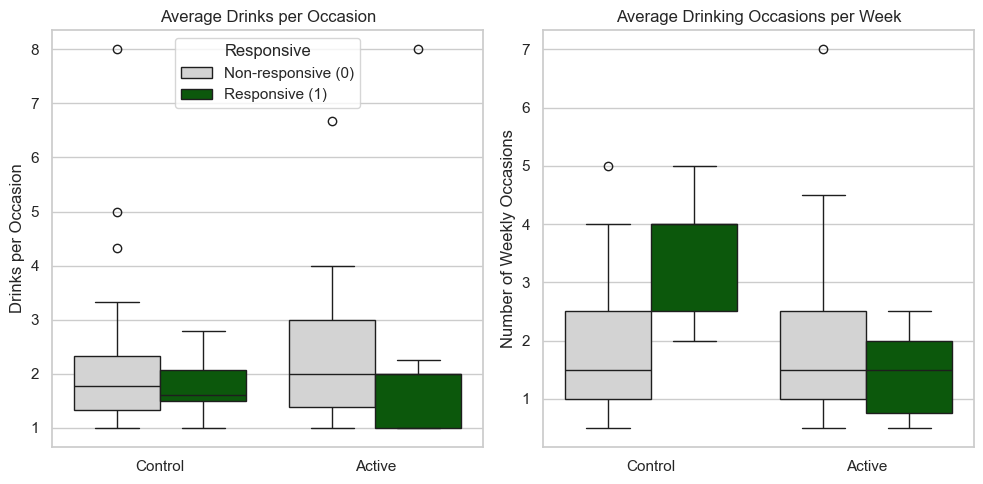

,Measure,Responsive Mean,Non-responsive Mean,t,p
0,Control – Drinks per Occasion,1.771,2.099,-1.136,0.263
1,Active – Drinks per Occasion,2.114,2.254,-0.219,0.830
2,Control – Drinking Occasions per Week,3.455,1.764,4.677,0.000
3,Active – Drinking Occasions per Week,1.409,1.861,-1.424,0.163


In [54]:
# --- Merge and filter ---
study_2_response = data_study2.merge(b2_group_subjective_study2, on='id', how='left')

# Compute intersection of valid IDs
valid_ids = (
    set(data_study2['id'])
    & set(baseline_demo_study2['id'])
    & set(b2_group_subjective_study2['id'])
)
print("Valid IDs:", len(valid_ids))
pd.Series(sorted(valid_ids), name="id").to_csv("../data/study_2_ids.csv", index=False)

# Keep only participants present in all three datasets
data_study2 = data_study2[data_study2['id'].isin(valid_ids)].copy()
study_2_response = study_2_response[study_2_response['id'].isin(valid_ids)].copy()

# Ensure drinks_number is numeric
data_study2['drinks_number'] = pd.to_numeric(data_study2['drinks_number'], errors='coerce')

# --- Aggregate per participant and week type ---
weekly_stats_2 = (
    data_study2
    .groupby(['id', 'active_week'])
    .agg(
        total_drinks=('drinks_number', 'sum'),
        occasions_number=('drinks_number', lambda x: (x > 0).sum())
    )
    .reset_index()
)

summary_2 = (
    weekly_stats_2
    .pivot(index='id', columns='active_week', values=['total_drinks', 'occasions_number'])
    .fillna(0)
)

summary_2.columns = [f"{col[0]}_{col[1]}" for col in summary_2.columns]
summary_2 = summary_2.reset_index()

# --- Compute per-person averages ---
summary_2['avg_drinks_active'] = summary_2['total_drinks_active'] / summary_2['occasions_number_active']
summary_2['avg_drinks_control'] = summary_2['total_drinks_control'] / summary_2['occasions_number_control']
summary_2['avg_occasions_active'] = summary_2['occasions_number_active'] / 2
summary_2['avg_occasions_control'] = summary_2['occasions_number_control'] / 2

# --- Merge with responsiveness info ---
merged_final_2 = summary_2.merge(
    responsive_study2[['id', 'responsive']],
    on='id',
    how='inner'
)

print("Unique IDs in merged_final_2:", merged_final_2['id'].nunique())


merged_final_2.dropna(inplace=True)
merged_final_2 = merged_final_2[merged_final_2['id'].isin(b2_group_subjective_study2['id'])]

# --- Summary statistics ---
stats_2 = (
    merged_final_2
    .groupby('responsive')[[
        'avg_drinks_control', 'avg_drinks_active',
        'avg_occasions_control', 'avg_occasions_active'
    ]]
    .agg(['mean', 'median', 'std', 'min', 'max'])
    .round(2)
)

# Flatten for readability
stats_2.columns = [f"{col[0]}_{col[1]}" for col in stats_2.columns]
stats_2 = stats_2.reset_index()
print(stats_2)

# --- Prepare plotting ---
plot_df_2 = merged_final_2.melt(
    id_vars='responsive',
    value_vars=[
        'avg_drinks_control', 'avg_drinks_active',
        'avg_occasions_control', 'avg_occasions_active'
    ],
    var_name='measure',
    value_name='value'
)

plot_df_2['type'] = plot_df_2['measure'].apply(lambda x: 'Drinks' if 'drinks' in x else 'Occasions')
plot_df_2['condition'] = plot_df_2['measure'].apply(lambda x: 'Active' if 'active' in x else 'Control')

palette = {0: 'lightgray', 1: 'darkgreen'}

sns.set(style='whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)

# --- Drinks plot ---
sns.boxplot(
    data=plot_df_2[plot_df_2['type'] == 'Drinks'],
    x='condition', y='value', hue='responsive',
    ax=axes[0], palette=palette
)
axes[0].set_title('Average Drinks per Occasion')
axes[0].set_xlabel('')
axes[0].set_ylabel('Drinks per Occasion')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['Non-responsive (0)', 'Responsive (1)'],
               title='Responsive', facecolor='white', frameon=True)

# --- Occasions plot ---
sns.boxplot(
    data=plot_df_2[plot_df_2['type'] == 'Occasions'],
    x='condition', y='value', hue='responsive',
    ax=axes[1], palette=palette
)
axes[1].set_title('Average Drinking Occasions per Week')
axes[1].set_xlabel('')
axes[1].set_ylabel('Number of Weekly Occasions')
axes[1].legend().remove()

plt.tight_layout()
plt.show()

# --- Welch’s t-tests ---
tests_2 = [
    ('avg_drinks_control', 'Control – Drinks per Occasion'),
    ('avg_drinks_active', 'Active – Drinks per Occasion'),
    ('avg_occasions_control', 'Control – Drinking Occasions per Week'),
    ('avg_occasions_active', 'Active – Drinking Occasions per Week')
]

results_2 = []

for var, label in tests_2:
    res_vals = merged_final_2.loc[merged_final_2['responsive'] == 1, var].dropna()
    nonres_vals = merged_final_2.loc[merged_final_2['responsive'] == 0, var].dropna()
    t_stat, p_val = ttest_ind(res_vals, nonres_vals, equal_var=False)
    results_2.append({
        "Measure": label,
        "Responsive Mean": res_vals.mean(),
        "Non-responsive Mean": nonres_vals.mean(),
        "t": t_stat,
        "p": p_val
    })

test_df_2 = pd.DataFrame(results_2).round(3)
test_df_2


In [55]:
stats_2

,responsive,avg_drinks_control_mean,avg_drinks_control_median,avg_drinks_control_std,avg_drinks_control_min,avg_drinks_control_max,avg_drinks_active_mean,avg_drinks_active_median,avg_drinks_active_std,avg_drinks_active_min,...,avg_occasions_control_mean,avg_occasions_control_median,avg_occasions_control_std,avg_occasions_control_min,avg_occasions_control_max,avg_occasions_active_mean,avg_occasions_active_median,avg_occasions_active_std,avg_occasions_active_min,avg_occasions_active_max
0,0,2.10,1.78,1.37,1.0,8.0,2.25,2.0,1.20,1.0,...,1.76,1.5,1.09,0.5,5.0,1.86,1.5,1.42,0.5,7.0
1,1,1.77,1.60,0.59,1.0,2.8,2.11,2.0,2.02,1.0,...,3.45,4.0,1.04,2.0,5.0,1.41,1.5,0.70,0.5,2.5


In [56]:
merged_final_2 = summary_2.merge(
    responsive_study2[['id', 'responsive']],
    on='id',
    how='inner'
)

# --- Count responders vs non-responders ---
resp_counts = merged_final_2['responsive'].value_counts().rename_axis('responsive').reset_index(name='count')
print("\nNumber of responsive vs non-responsive participants:")
print(resp_counts)
print(f"Total: {resp_counts['count'].sum()} participants")

print("Unique IDs in merged_final_2:", merged_final_2['id'].nunique())


Number of responsive vs non-responsive participants:
   responsive  count
0           0    100
1           1     14
Total: 114 participants
Unique IDs in merged_final_2: 114


In [57]:
merged

,id,avg_alcmost_freq,avg_alcmost,alc_norm_5_r,groupAtt_alc,groupAtt_binge,responsive,gender_numeric,age,income_numeric,college_year,race_numeric
0,muric525,24.000000,2.000000,2.0,3.0,2.0,0,2.0,18.0,20.0,1.0,Asian
1,muric531,68.909091,1.500000,2.0,3.0,3.0,0,2.0,19.0,6.0,1.0,White
2,muri371,70.666667,2.666667,1.0,5.0,2.0,0,2.0,21.0,20.0,4.0,Asian
3,muri374,148.444444,3.722222,4.0,5.0,4.0,0,2.0,20.0,20.0,3.0,Asian
4,muri379,59.428571,2.142857,2.0,5.0,3.0,0,1.0,22.0,15.0,4.0,Asian
...,...,...,...,...,...,...,...,...,...,...,...,...
109,muri341,76.750000,2.843750,2.0,4.0,4.0,1,2.0,21.0,15.0,4.0,White
110,muri344,95.800000,7.500000,4.0,5.0,5.0,0,2.0,19.0,8.0,2.0,"White,Native Hawaiian or Other Pacific Islander"
111,muri354,6.000000,1.400000,2.0,3.0,1.0,0,2.0,22.0,2.0,4.0,White
112,muri359,116.444444,7.055556,2.0,5.0,4.0,0,2.0,18.0,20.0,1.0,White


### Characteristics of Mindful vs Perspective

In [58]:
mindful_ids_study2 = study_2_response.loc[study_2_response["condition"] == "mindful", "id"].unique()
perspective_ids_study2 = study_2_response.loc[study_2_response["condition"] == "perspective", "id"].unique()

print("Mindful IDs:", len(mindful_ids_study2))
print("Perspective IDs:", len(perspective_ids_study2))

Mindful IDs: 58
Perspective IDs: 56


In [59]:
def describe_subgroup(df, label):
    print(f"\n=== {label} Group ===")
    age_mean = df['age'].mean()
    age_sd = df['age'].std()
    age_min = df['age'].min()
    age_max = df['age'].max()
    print(f"Age: M = {round(age_mean, 2)}, SD = {round(age_sd, 2)}, Min = {age_min}, Max = {age_max}")

    gender_counts = df['gender_numeric'].value_counts(dropna=False).sort_index()
    gender_percent = round(100 * gender_counts / gender_counts.sum(), 1)
    print("Gender distribution:")
    for gender, count in gender_counts.items():
        label = "Missing" if pd.isna(gender) else f"Gender {gender}"
        print(f"  {label}: {count} ({gender_percent[gender]}%)")

    responsive_counts = df['responsive'].value_counts(dropna=False).sort_index()
    responsive_percent = round(100 * responsive_counts / responsive_counts.sum(), 1)
    print("Responsive distribution:")
    for resp, count in responsive_counts.items():
        label = "Missing" if pd.isna(resp) else f"Responsive = {resp}"
        print(f"  {label}: {count} ({responsive_percent[resp]}%)")

    race_counts = df['race_numeric'].value_counts(dropna=False).sort_index()
    race_percent = round(100 * race_counts / race_counts.sum(), 1)
    print("Race distribution:")
    for race, count in race_counts.items():
        label = "Missing" if pd.isna(race) else f"Race {race}"
        print(f"  {label}: {count} ({race_percent[race]}%)")

    college_counts = df['college_year'].value_counts(dropna=False).sort_index()
    college_percent = round(100 * college_counts / college_counts.sum(), 1)
    print("College year distribution:")
    for year, count in college_counts.items():
        label = "Missing" if pd.isna(year) else f"Year {year}"
        print(f"  {label}: {count} ({college_percent[year]}%)")

    income_mean = round(df['income_numeric'].mean(), 2)
    income_sd = round(df['income_numeric'].std(), 2)
    income_median = df['income_numeric'].median()
    income_min = df['income_numeric'].min()
    income_max = df['income_numeric'].max()
    print(f"Income: Median = {income_median}, Mean = {income_mean}, SD = {income_sd}")
    print(f"The household income ranged between {income_min} and {income_max}.\n")

# --- Subset by intervention type ---
mindful_df = merged[merged['id'].isin(mindful_ids_study2)]
perspective_df = merged[merged['id'].isin(perspective_ids_study2)]

# --- Run for both groups ---
describe_subgroup(mindful_df, "Mindfulness")
describe_subgroup(perspective_df, "Perspective-taking")



=== Mindfulness Group ===
Age: M = 20.22, SD = 1.11, Min = 18.0, Max = 22.0
Gender distribution:
  Gender 1.0: 10 (17.2%)
  Gender 2.0: 48 (82.8%)
Responsive distribution:
  Responsive = 0: 50 (86.2%)
  Responsive = 1: 8 (13.8%)
Race distribution:
  Race Asian: 24 (41.4%)
  Race Black or African American: 6 (10.3%)
  Race Black or African American,Asian: 1 (1.7%)
  Race Latino/a: 3 (5.2%)
  Race White: 20 (34.5%)
  Race White,Asian: 1 (1.7%)
  Race White,Latino/a: 2 (3.4%)
  Missing: 1 (1.7%)
College year distribution:
  Year 1.0: 7 (12.1%)
  Year 2.0: 15 (25.9%)
  Year 3.0: 14 (24.1%)
  Year 4.0: 20 (34.5%)
  Year 5.0: 1 (1.7%)
  Missing: 1 (1.7%)
Income: Median = 15.0, Mean = 14.12, SD = 6.81
The household income ranged between 0.0 and 20.0.


=== Perspective-taking Group ===
Age: M = 20.07, SD = 1.41, Min = 18.0, Max = 25.0
Gender distribution:
  Gender 1.0: 13 (23.2%)
  Gender 2.0: 43 (76.8%)
Responsive distribution:
  Responsive = 0: 50 (89.3%)
  Responsive = 1: 6 (10.7%)
Race di

In [60]:
## Adherence by intervention type
cond_map = study_2_response[['id', 'condition']].drop_duplicates('id')

# --- Merge condition with adherence ---
merged_df = df_adherence_2.merge(cond_map, on='id', how='inner')

# --- Check ---
print(merged_df['condition'].value_counts(dropna=False))

# --- Compute adherence stats per condition ---
adherence_stats = (
    merged_df
    .groupby('condition')['alc_responses']
    .agg(['mean', 'std', 'min', 'max'])
    .round(2)
)

print(adherence_stats/56)


condition
mindful        58
perspective    56
Name: count, dtype: int64
                 mean       std       min  max
condition                                     
mindful      0.824821  0.226786  0.053571  1.0
perspective  0.780536  0.313929  0.017857  1.0


### Baseline drinking levels

In [61]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Load valid IDs
valid_ids = pd.read_csv("../data/study_2_ids.csv")['id']

# Filter response dataframe
response = responsive_study2[
    responsive_study2['id'].isin(valid_ids)
]

# Filter baseline alcohol self-report dataframe
baseline_alc_self = baseline_demo_all[
    baseline_demo_all['pID'].isin(valid_ids)
]

# Merge responder status
baseline_alc_self = baseline_alc_self.merge(
    response[['id', 'responsive']],
    left_on='pID',
    right_on='id',
    how='left'
)

# Count how many remain after merge
print("Participants after merge:", baseline_alc_self['pID'].nunique())
print("Rows after merge:", len(baseline_alc_self))

# Define numeric columns
alc_self_cols = ['freq_self', 'amount_self']

# Convert to numeric
for c in alc_self_cols:
    baseline_alc_self[c] = pd.to_numeric(baseline_alc_self[c], errors='coerce')

# Remove invalid (<0) values
baseline_alc_self = baseline_alc_self[
    (baseline_alc_self['freq_self'] >= 0) &
    (baseline_alc_self['amount_self'] >= 0)
]

print("Participants after removing invalid values:", baseline_alc_self['pID'].nunique())
print("Rows after removing invalid:", len(baseline_alc_self))

# Split by responder status
baseline_responders = baseline_alc_self[baseline_alc_self['responsive'] == 1]
baseline_non_responders = baseline_alc_self[baseline_alc_self['responsive'] == 0]

# Summary stats
baseline_responder_stats = (
    baseline_responders[alc_self_cols]
    .agg(['mean', 'median', 'std', 'min', 'max'])
    .T
    .round(2)
)

baseline_non_responder_stats = (
    baseline_non_responders[alc_self_cols]
    .agg(['mean', 'median', 'std', 'min', 'max'])
    .T
    .round(2)
)

print("=== Baseline self-report: Responders ===")
print(baseline_responder_stats)
print("\n=== Baseline self-report: Non-Responders ===")
print(baseline_non_responder_stats)

# Mann-Whitney U
for col in alc_self_cols:
    x = baseline_responders[col].dropna()
    y = baseline_non_responders[col].dropna()
    stat, p = mannwhitneyu(x, y, alternative="two-sided")
    print(f"{col}: U = {stat:.2f}, p = {p:.3f}")


Participants after merge: 112
Rows after merge: 112
Participants after removing invalid values: 90
Rows after removing invalid: 90
=== Baseline self-report: Responders ===
              mean  median     std   min    max
freq_self    78.25    52.0  100.06  12.0  365.0
amount_self   3.75     3.5    2.34   1.0    7.5

=== Baseline self-report: Non-Responders ===
              mean  median    std  min    max
freq_self    69.79    52.0  56.97  1.5  182.0
amount_self   3.57     3.5   1.67  1.0    7.5
freq_self: U = 454.00, p = 0.869
amount_self: U = 473.50, p = 0.951


In [62]:
# Unique controls with IDs
control_unique = (
    data_study2_control[['id', 'alc_responses']]
    .drop_duplicates('id')
    .copy()
)

control_ids = control_unique[['id']].drop_duplicates('id')

# Baseline rows for controls
baseline_controls = baseline_demo_all[
    baseline_demo_all['pID'].isin(control_ids['id'])
].copy()

# Ensure numeric
for c in ['freq_self', 'amount_self']:
    baseline_controls[c] = pd.to_numeric(baseline_controls[c], errors='coerce')

# Remove invalid (<0)
baseline_controls = baseline_controls[
    (baseline_controls['freq_self'] >= 0) &
    (baseline_controls['amount_self'] >= 0)
]

print("Control participants:", baseline_controls['pID'].nunique())
print("Control rows:", len(baseline_controls))

baseline_intervention = baseline_alc_self[
    baseline_alc_self['responsive'].isin([0, 1])
].copy()

control_stats = (
    baseline_controls[['freq_self', 'amount_self']]
    .agg(['mean', 'median', 'std', 'min', 'max'])
    .T.round(2)
)

print("=== Baseline self-report: Controls ===")
print(control_stats)

from scipy.stats import mannwhitneyu

for col in ['freq_self', 'amount_self']:
    x = baseline_controls[col].dropna()
    y = baseline_intervention[col].dropna()
    stat, p = mannwhitneyu(x, y, alternative='two-sided')
    print(f"[MWU] {col}: U = {stat:.2f}, p = {p:.3f}")

from scipy.stats import ttest_ind

for col in ['freq_self', 'amount_self']:
    x = baseline_controls[col].dropna()
    y = baseline_intervention[col].dropna()
    t, p = ttest_ind(x, y, equal_var=False)
    print(f"[Welch t-test] {col}: t = {t:.2f}, p = {p:.3f}")




Control participants: 39
Control rows: 39
=== Baseline self-report: Controls ===
              mean  median    std  min    max
freq_self    97.53   104.0  65.36  1.5  286.0
amount_self   3.60     3.5   1.94  1.0    7.5
[MWU] freq_self: U = 2262.00, p = 0.008
[MWU] amount_self: U = 1728.00, p = 0.887
[Welch t-test] freq_self: t = 2.14, p = 0.036
[Welch t-test] amount_self: t = 0.02, p = 0.982


In [63]:
import pandas as pd
from scipy.stats import mannwhitneyu, ttest_ind

# === 1. Load fresh data ===

# Baseline alcohol self-report (all participants, all studies)
baseline_demo_all = pd.read_csv(
    "../data/baseline/00_baseline_survey.csv",
    index_col=0
)

# Study 2 responsiveness file (intervention arms)
responsive_study2 = pd.read_csv("../data/intervention_time/responsiveness_study2.csv")

# Valid Study 2 intervention IDs
valid_ids = pd.read_csv("../data/study_2_ids.csv")['id']

# === 2. Build intervention baseline df (Study 2, responders + non-responders) ===

baseline_alc_self = baseline_demo_all[
    baseline_demo_all['pID'].isin(valid_ids)
].copy()

baseline_alc_self = baseline_alc_self.merge(
    responsive_study2[['id', 'responsive']],
    left_on='pID',
    right_on='id',
    how='left'
)

print("Intervention participants after merge:", baseline_alc_self['pID'].nunique())
print("Intervention rows after merge:", len(baseline_alc_self))

alc_self_cols = ['freq_self', 'amount_self']

for c in alc_self_cols:
    baseline_alc_self[c] = pd.to_numeric(baseline_alc_self[c], errors='coerce')

baseline_alc_self = baseline_alc_self[
    (baseline_alc_self['freq_self'] >= 0) &
    (baseline_alc_self['amount_self'] >= 0)
]

print("Intervention participants after cleaning:", baseline_alc_self['pID'].nunique())
print("Intervention rows after cleaning:", len(baseline_alc_self))

baseline_intervention = baseline_alc_self[
    baseline_alc_self['responsive'].isin([0, 1])
].copy()

# === 3. Build control baseline df (Study 2 controls) ===

# data_study2_control is assumed to already be loaded elsewhere
control_unique = (
    data_study2_control[['id', 'alc_responses']]
    .drop_duplicates('id')
    .copy()
)

print("Unique control IDs in data_study2_control:", control_unique['id'].nunique())

baseline_controls = baseline_demo_all[
    baseline_demo_all['pID'].isin(control_unique['id'])
].copy()

for c in alc_self_cols:
    baseline_controls[c] = pd.to_numeric(baseline_controls[c], errors='coerce')

baseline_controls = baseline_controls[
    (baseline_controls['freq_self'] >= 0) &
    (baseline_controls['amount_self'] >= 0)
]

print("Control participants with baseline alcohol data:", baseline_controls['pID'].nunique())
print("Control rows after cleaning:", len(baseline_controls))

# === 4. Summary stats for controls ===

control_stats = (
    baseline_controls[alc_self_cols]
    .agg(['mean', 'median', 'std', 'min', 'max'])
    .T.round(2)
)

print("=== Baseline self-report: Controls ===")
print(control_stats)

# === 5. MWU and Welch t-tests: controls vs intervention (pooled) ===

for col in alc_self_cols:
    x = baseline_controls[col].dropna()
    y = baseline_intervention[col].dropna()

    print(f"\n=== {col} ===")
    print("n_controls:", len(x), "n_intervention:", len(y))

    # Mann–Whitney U
    stat_u, p_u = mannwhitneyu(x, y, alternative='two-sided')
    print(f"[MWU] U = {stat_u:.2f}, p = {p_u:.3f}")

    # Welch t-test
    t, p_t = ttest_ind(x, y, equal_var=False)
    print(f"[Welch t-test] t = {t:.2f}, p = {p_t:.3f}")


Intervention participants after merge: 112
Intervention rows after merge: 112
Intervention participants after cleaning: 90
Intervention rows after cleaning: 90
Unique control IDs in data_study2_control: 71
Control participants with baseline alcohol data: 39
Control rows after cleaning: 39
=== Baseline self-report: Controls ===
              mean  median    std  min    max
freq_self    97.53   104.0  65.36  1.5  286.0
amount_self   3.60     3.5   1.94  1.0    7.5

=== freq_self ===
n_controls: 39 n_intervention: 90
[MWU] U = 2262.00, p = 0.008
[Welch t-test] t = 2.14, p = 0.036

=== amount_self ===
n_controls: 39 n_intervention: 90
[MWU] U = 1728.00, p = 0.887
[Welch t-test] t = 0.02, p = 0.982


## Types of groups

In [64]:
baseline_group_ids = baseline_demo_all[['pID', 'group_type', 'group_gender', 'groupID']]
ids_study_1 = pd.read_csv('../data/study_1_ids.csv')
ids_study_2 = pd.read_csv('../data/study_2_ids.csv')

# baseline_group_ids

In [65]:
# Ensure consistent ID column names
ids_study_1 = ids_study_1.rename(columns={"id": "pID"})
ids_study_2 = ids_study_2.rename(columns={"id": "pID"})

# Filter baseline to each study
study1 = baseline_group_ids[baseline_group_ids["pID"].isin(ids_study_1["pID"])]
study2 = baseline_group_ids[baseline_group_ids["pID"].isin(ids_study_2["pID"])]

def summarize(study_df, label):
    print(f"\n=== {label} ===")

    # Unique groups
    n_groups = study_df["groupID"].nunique()
    print("Total unique groups:", n_groups)

    # Groups by type
    groups_by_type = (
        study_df.drop_duplicates("groupID")
        .groupby("group_type")["groupID"]
        .nunique()
    )
    print("\nGroups by type:")
    print(groups_by_type)

    # Groups by gender
    groups_by_gender = (
        study_df.drop_duplicates("groupID")
        .groupby("group_gender")["groupID"]
        .nunique()
    )
    print("\nGroups by gender:")
    print(groups_by_gender)

summarize(study1, "Study 1")
summarize(study2, "Study 2")



=== Study 1 ===
Total unique groups: 10

Groups by type:
group_type
greek              2
other              1
performing_arts    4
sports             3
Name: groupID, dtype: int64

Groups by gender:
group_gender
F     2
M     1
MF    7
Name: groupID, dtype: int64

=== Study 2 ===
Total unique groups: 22

Groups by type:
group_type
greek              7
other              1
performing_arts    8
sports             5
technology         1
Name: groupID, dtype: int64

Groups by gender:
group_gender
F      6
M      3
MF    13
Name: groupID, dtype: int64


## Training / Validation

### Nested CV

## Training Code - Random Forest

In [66]:
shap.initjs()

def run_rf_train_test(dataframes, param_grid, eval_metrics, outer_reps=50, k=5, CV_reps=5, model_choice_metric='f1', 
                      res_dir=f"./results/", model_type='xgb', test_set=0.3, permutation=False, random_state=321):

    timestamp = int(time.time())
    res_dir = f"{res_dir}/{timestamp}_{SEED}_{model_type}_outer{outer_reps}_cvrep{CV_reps}_k{k}_{model_choice_metric}_testsize{test_set}_perm{permutation}/"
    os.makedirs(res_dir, exist_ok=True)
    
    keys = list(dataframes.keys())

    # combine data categories
    combinations_keys = list(chain.from_iterable(combinations(keys, r) for r in range(1, 3)))
    combo_validation_scores = {}
    combo_test_scores = {}
    best_models = {} 
    best_shap_vals = {}
    best_paramses = {}

    all_val_scores = {}
    all_test_scores = {}
    all_models_sub = []

    for combo in tqdm(combinations_keys):
        validation_scores = {metric: [] for metric in eval_metrics}
        test_scores = {metric: [] for metric in eval_metrics}
        merged_df = dataframes[combo[0]].copy()
        top_models_group_sub = []
        
        for key in combo[1:]:
            merged_df = merged_df.merge(dataframes[key].copy(), how='inner', on=['id', TARGET_VAR])
        if TARGET_VAR not in merged_df.columns:
            raise ValueError(f"Target variable '{TARGET_VAR}' not found in merged dataframe for combo: {combo}")
    
        all_shap_values = []
        all_test_data = []
        best_overall_score = -np.inf 
        best_model_for_combo = None
        best_params_for_combo = None
        best_shap_for_combo = None

        for _ in range(outer_reps): # i repetitions of train/test

            # Prepare train/test split for this i (random & stratified)
            X_data, Y_data, X_test, Y_test, x_test_index = prepare_features_and_targets(merged_df.copy(), test_set=test_set, target_var=TARGET_VAR)

            # Shuffle labels for permutation tests
            if permutation:
                Y_data = Y_data.sample(frac=1, random_state=None).reset_index(drop=True)
                Y_test = Y_test.sample(frac=1, random_state=None).reset_index(drop=True)

            best_model, best_scores, best_params = random_forest_kfold_grid_search(X_data, Y_data, 
                                                                                    param_grid, k=k, 
                                                                                    CV_reps=CV_reps, 
                                                                                    eval_metric=eval_metrics,
                                                                                    model_choice_metric=model_choice_metric,
                                                                                    res_dir=res_dir,
                                                                                    model_type=model_type,
                                                                                    combo=combo, 
                                                                                    random_state=random_state)
            # Collect metrics
            for metric, score in best_scores.items():
                validation_scores[metric].append(score)

            # Retrain the best model on the full training dataset and evaluate on the test set
            best_model.fit(X_data, Y_data)
            test_predictions = best_model.predict(X_test)
            proba_predictions = best_model.predict_proba(X_test)[:, 1]

            pred_df = pd.DataFrame({
                "id": x_test_index,
                "predicted_probability": proba_predictions
            })

            # Save to CSV
            out_path = "./predicted_probabilities.csv"
            pred_df.to_csv(out_path, mode="a", header=not os.path.exists(out_path), index=False)

            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(X_test) 
            shap_values = shap_values[:, :, 1]

            # Append SHAP values and test data for later aggregation
            all_shap_values.append(shap_values)
            all_test_data.append(pd.DataFrame(X_test))
            print(f"Xtest columns: {X_test.columns}")

            if best_scores[model_choice_metric] > best_overall_score:
                best_overall_score = best_scores[model_choice_metric]
                best_model_for_combo = best_model
                best_params_for_combo = best_params
                best_shap_for_combo = shap_values  # Store SHAP values if needed

            if combo == ('group_sub',):
                top_models_group_sub.append((best_scores[model_choice_metric], deepcopy(best_model)))

            # Calculate and append metrics for the test set
            test_scores = compute_test_metrics(Y_test, test_predictions, proba_predictions, test_scores)

        # Keep track of the best model based on the model_choice_metric
        if combo not in best_models or best_scores[model_choice_metric] > combo_validation_scores[combo][model_choice_metric]['mean']:
            best_models[combo] = best_model_for_combo
            
            joblib.dump(best_model_for_combo, f"{res_dir}/model_{'_'.join(combo)}.joblib")

            best_shap_vals[combo] = best_shap_for_combo
            best_paramses[combo] = best_params_for_combo

            # Save top 10 models for group_sub combo
            if combo == ('group_sub',):
                top_models_group_sub = locals().get("top_models_group_sub", [])
                top_models_group_sub.append((best_overall_score, deepcopy(best_model_for_combo)))

                # Sort and save top 10 by score
                top_models_group_sub.sort(key=lambda x: x[0], reverse=True)
                top10 = top_models_group_sub[:100]

                subdir = os.path.join(res_dir, "top100_group_sub_models")
                os.makedirs(subdir, exist_ok=True)

                for i, (score, model) in enumerate(top10):
                    joblib.dump(model, f"{subdir}/model_rank{i+1}_score{score:.4f}.joblib")

                # Store back in locals so it's not overwritten each time
                locals()["top_models_group_sub"] = top_models_group_sub

        top2_features = plot_shap_summary_with_percentages(all_shap_values, all_test_data, res_dir, combo)

        if not model_type=='dt':
            plot_pdp_across_runs(
                best_model=best_model_for_combo,
                res_dir=res_dir,
                all_test_data=all_test_data,
                interaction_pair=tuple(top2_features),
                ids = []
            )

        # Calculate mean and 95% CI for validation scores
        z = norm.ppf(0.975)  # 95% confidence level
        final_validation_scores = {}
        for metric, scores in validation_scores.items():
            mean_score = np.mean(scores)
            std_error = np.std(scores, ddof=1) / np.sqrt(len(scores))
            ci_lower = mean_score - z * std_error
            ci_upper = mean_score + z * std_error
            final_validation_scores[metric] = {
                'mean': mean_score,
                '95%_CI': (ci_lower, ci_upper)
            }
        combo_validation_scores[combo] = final_validation_scores
        all_val_scores[combo] = validation_scores
        save_metrics_to_csv(all_val_scores, res_dir, 'all_val_scores.csv')

        # Calculate mean and 95% CI for test scores
        final_test_scores = {}
        for metric, scores in test_scores.items():
            mean_score = np.mean(scores)
            std_error = np.std(scores, ddof=1) / np.sqrt(len(scores))
            ci_lower = mean_score - z * std_error
            ci_upper = mean_score + z * std_error
            final_test_scores[metric] = {
                'mean': mean_score,
                '95%_CI': (ci_lower, ci_upper)
            }
        combo_test_scores[combo] = final_test_scores
        all_test_scores[combo] = test_scores
        save_metrics_to_csv(all_test_scores, res_dir, 'all_test_scores.csv')

        # For validation scores
        df_val = flatten_score_dict(combo_validation_scores, res_dir=res_dir, filename="validation_scores.csv")
        # For test scores
        df_test = flatten_score_dict(combo_test_scores, res_dir=res_dir, filename="test_scores.csv")
        
    return res_dir

## Training Code - SVM

In [67]:
def run_svm_train_test(
    dataframes, param_grid, eval_metrics, outer_reps=50, k=5, CV_reps=5,
    model_choice_metric='roc_auc', res_dir=f"./results_svm/",
    model_type='svm', test_set=0.3, permutation=False, random_state=None
):
    """
    Mirrors your LR runner, but with SVM. Saves top 100 models for ('group_sub',).
    """
    timestamp = int(time.time())
    res_dir = f"{res_dir}/{timestamp}_{random_state}_{model_type}_outer{outer_reps}_cvrep{CV_reps}_k{k}_{model_choice_metric}_testsize{test_set}_perm{permutation}/"
    os.makedirs(res_dir, exist_ok=True)

    keys = list(dataframes.keys())
    combinations_keys = list(chain.from_iterable(combinations(keys, r) for r in range(1, 3)))

    combo_validation_scores = {}
    combo_test_scores = {}
    best_models = {}
    best_paramses = {}

    all_val_scores = {}
    all_test_scores = {}
    all_models_sub = []

    for combo in tqdm(combinations_keys):
        validation_scores = {metric: [] for metric in eval_metrics}
        test_scores = {metric: [] for metric in eval_metrics}

        merged_df = dataframes[combo[0]].copy()
        top_models_group_sub = []

        for key in combo[1:]:
            merged_df = merged_df.merge(dataframes[key].copy(), how='inner', on=['id', TARGET_VAR])

        if TARGET_VAR not in merged_df.columns:
            raise ValueError(f"Target variable '{TARGET_VAR}' not found in merged dataframe for combo: {combo}")

        best_overall_score = -np.inf
        best_model_for_combo = None
        best_params_for_combo = None

        for _ in range(outer_reps):
            # Train/test split
            X_data, Y_data, X_test, Y_test = prepare_features_and_targets(merged_df.copy(), test_set=test_set, target_var=TARGET_VAR)

            # Optional permutation
            if permutation:
                Y_data = Y_data.sample(frac=1, random_state=None).reset_index(drop=True)
                Y_test = Y_test.sample(frac=1, random_state=None).reset_index(drop=True)

            # Inner CV selection
            best_model, best_scores, best_params = svm_kfold_grid_search(
                X_data, Y_data, param_grid, k=k, CV_reps=CV_reps,
                eval_metric=eval_metrics, model_choice_metric=model_choice_metric, combo=combo
            )

            # Record inner-CV selection metric(s)
            for metric, score in best_scores.items():
                validation_scores[metric].append(score)

            # Retrain on full training data and evaluate on test
            best_model.fit(X_data, Y_data)
            test_predictions = best_model.predict(X_test)
            proba_predictions = best_model.predict_proba(X_test)[:, 1]

            if best_scores.get(model_choice_metric, -np.inf) > best_overall_score:
                best_overall_score = best_scores.get(model_choice_metric, -np.inf)
                best_model_for_combo = best_model
                best_params_for_combo = best_params

            if combo == ('group_sub',):
                top_models_group_sub.append((best_scores.get(model_choice_metric, -np.inf), deepcopy(best_model)))

            # Accumulate test metrics
            test_scores = compute_test_metrics(Y_test, test_predictions, proba_predictions, test_scores)

        # Keep best model; save
        if combo not in best_models or best_overall_score > combo_validation_scores.get(combo, {}).get(model_choice_metric, {'mean': -np.inf})['mean']:
            best_models[combo] = best_model_for_combo
            joblib.dump(best_model_for_combo, f"{res_dir}/model_{'_'.join(combo)}.joblib")
            best_paramses[combo] = best_params_for_combo

            if combo == ('group_sub',):
                top_models_group_sub = locals().get("top_models_group_sub", [])
                top_models_group_sub.append((best_overall_score, deepcopy(best_model_for_combo)))
                top_models_group_sub.sort(key=lambda x: x[0], reverse=True)
                top10 = top_models_group_sub[:100]

                subdir = os.path.join(res_dir, "top100_group_sub_models")
                os.makedirs(subdir, exist_ok=True)
                for i, (score, model) in enumerate(top10):
                    joblib.dump(model, f"{subdir}/model_rank{i+1}_score{score:.4f}.joblib")
                locals()["top_models_group_sub"] = top_models_group_sub

        # Summary stats (mean, normal-approx 95% CI)
        z = norm.ppf(0.975)
        final_validation_scores = {}
        for metric, scores in validation_scores.items():
            if len(scores) == 0 or np.all(pd.isna(scores)):
                mean_score, ci_lower, ci_upper = np.nan, np.nan, np.nan
            else:
                mean_score = np.nanmean(scores)
                std_error = np.nanstd(scores, ddof=1) / np.sqrt(np.sum(~pd.isna(scores)))
                ci_lower = mean_score - z * std_error
                ci_upper = mean_score + z * std_error
            final_validation_scores[metric] = {'mean': mean_score, '95%_CI': (ci_lower, ci_upper)}
        combo_validation_scores[combo] = final_validation_scores
        all_val_scores[combo] = validation_scores
        save_metrics_to_csv(all_val_scores, res_dir, 'all_val_scores.csv')

        final_test_scores = {}
        for metric, scores in test_scores.items():
            if len(scores) == 0 or np.all(pd.isna(scores)):
                mean_score, ci_lower, ci_upper = np.nan, np.nan, np.nan
            else:
                mean_score = np.nanmean(scores)
                std_error = np.nanstd(scores, ddof=1) / np.sqrt(np.sum(~pd.isna(scores)))
                ci_lower = mean_score - z * std_error
                ci_upper = mean_score + z * std_error
            final_test_scores[metric] = {'mean': mean_score, '95%_CI': (ci_lower, ci_upper)}
        combo_test_scores[combo] = final_test_scores
        all_test_scores[combo] = test_scores
        save_metrics_to_csv(all_test_scores, res_dir, 'all_test_scores.csv')

        flatten_score_dict(combo_validation_scores, res_dir=res_dir, filename="validation_scores.csv")
        flatten_score_dict(combo_test_scores, res_dir=res_dir, filename="test_scores.csv")

    return res_dir

## Training Code - Logistic Regression

In [68]:
shap.initjs()

def run_lr_train_test(dataframes, param_grid, eval_metrics, outer_reps=50, k=5, CV_reps=5, model_choice_metric='f1', 
                      res_dir=f"./results/", model_type='xgb', test_set=0.3, permutation=False):

    timestamp = int(time.time())
    res_dir = f"{res_dir}/{timestamp}_{SEED}_{model_type}_outer{outer_reps}_cvrep{CV_reps}_k{k}_{model_choice_metric}_testsize{test_set}_perm{permutation}/"
    os.makedirs(res_dir, exist_ok=True)
    
    keys = list(dataframes.keys())

    # combine data categories
    combinations_keys = list(chain.from_iterable(combinations(keys, r) for r in range(1, 3)))
    combo_validation_scores = {}
    combo_test_scores = {}
    best_models = {} 
    best_shap_vals = {}
    best_paramses = {}

    all_val_scores = {}
    all_test_scores = {}
    all_models_sub = []

    for combo in tqdm(combinations_keys):
        validation_scores = {metric: [] for metric in eval_metrics}
        test_scores = {metric: [] for metric in eval_metrics}
        merged_df = dataframes[combo[0]].copy()
        top_models_group_sub = []
        
        for key in combo[1:]:
            merged_df = merged_df.merge(dataframes[key].copy(), how='inner', on=['id', TARGET_VAR])
        if TARGET_VAR not in merged_df.columns:
            raise ValueError(f"Target variable '{TARGET_VAR}' not found in merged dataframe for combo: {combo}")
    
        all_shap_values = []
        all_test_data = []
        best_overall_score = -np.inf 
        best_model_for_combo = None
        best_params_for_combo = None
        best_shap_for_combo = None

        for _ in range(outer_reps): # i repetitions of train/test

            # Prepare train/test split for this i (random & stratified)
            X_data, Y_data, X_test, Y_test = prepare_features_and_targets(merged_df.copy(), test_set=test_set, target_var=TARGET_VAR)

            # Shuffle labels for permutation tests
            if permutation:
                Y_data = Y_data.sample(frac=1, random_state=None).reset_index(drop=True)
                Y_test = Y_test.sample(frac=1, random_state=None).reset_index(drop=True)

            best_model, best_scores, best_params = logistic_regression_kfold_grid_search(X_data, Y_data, 
                                                                                    param_grid, k=k, 
                                                                                    CV_reps=CV_reps, 
                                                                                    eval_metric=eval_metrics,
                                                                                    model_choice_metric=model_choice_metric,
                                                                                    res_dir=res_dir,
                                                                                    combo=combo)
            # Collect metrics
            for metric, score in best_scores.items():
                validation_scores[metric].append(score)

            # Retrain the best model on the full training dataset and evaluate on the test set
            best_model.fit(X_data, Y_data)
            test_predictions = best_model.predict(X_test)
            proba_predictions = best_model.predict_proba(X_test)[:, 1]
            all_test_data.append(pd.DataFrame(X_test))

            if best_scores[model_choice_metric] > best_overall_score:
                best_overall_score = best_scores[model_choice_metric]
                best_model_for_combo = best_model
                best_params_for_combo = best_params
                # best_shap_for_combo = shap_values  # Store SHAP values if needed

            if combo == ('group_sub',):
                top_models_group_sub.append((best_scores[model_choice_metric], deepcopy(best_model)))

            # Calculate and append metrics for the test set
            test_scores = compute_test_metrics(Y_test, test_predictions, proba_predictions, test_scores)

        # Keep track of the best model based on the model_choice_metric
        if combo not in best_models or best_scores[model_choice_metric] > combo_validation_scores[combo][model_choice_metric]['mean']:
            best_models[combo] = best_model_for_combo
            
            joblib.dump(best_model_for_combo, f"{res_dir}/model_{'_'.join(combo)}.joblib")

            # best_shap_vals[combo] = best_shap_for_combo
            best_paramses[combo] = best_params_for_combo

            # Save top 10 models for group_sub combo
            if combo == ('group_sub',):
                top_models_group_sub = locals().get("top_models_group_sub", [])
                top_models_group_sub.append((best_overall_score, deepcopy(best_model_for_combo)))

                # Sort and save top 10 by score
                top_models_group_sub.sort(key=lambda x: x[0], reverse=True)
                top10 = top_models_group_sub[:100]

                subdir = os.path.join(res_dir, "top100_group_sub_models")
                os.makedirs(subdir, exist_ok=True)

                for i, (score, model) in enumerate(top10):
                    joblib.dump(model, f"{subdir}/model_rank{i+1}_score{score:.4f}.joblib")

                # Store back in locals so it's not overwritten each time
                locals()["top_models_group_sub"] = top_models_group_sub

        # Calculate mean and 95% CI for validation scores
        z = norm.ppf(0.975)  # 95% confidence level
        final_validation_scores = {}
        for metric, scores in validation_scores.items():
            mean_score = np.mean(scores)
            std_error = np.std(scores, ddof=1) / np.sqrt(len(scores))
            ci_lower = mean_score - z * std_error
            ci_upper = mean_score + z * std_error
            final_validation_scores[metric] = {
                'mean': mean_score,
                '95%_CI': (ci_lower, ci_upper)
            }
        combo_validation_scores[combo] = final_validation_scores
        all_val_scores[combo] = validation_scores
        save_metrics_to_csv(all_val_scores, res_dir, 'all_val_scores.csv')

        # Calculate mean and 95% CI for test scores
        final_test_scores = {}
        for metric, scores in test_scores.items():
            mean_score = np.mean(scores)
            std_error = np.std(scores, ddof=1) / np.sqrt(len(scores))
            ci_lower = mean_score - z * std_error
            ci_upper = mean_score + z * std_error
            final_test_scores[metric] = {
                'mean': mean_score,
                '95%_CI': (ci_lower, ci_upper)
            }
        combo_test_scores[combo] = final_test_scores
        all_test_scores[combo] = test_scores
        save_metrics_to_csv(all_test_scores, res_dir, 'all_test_scores.csv')

        # For validation scores
        df_val = flatten_score_dict(combo_validation_scores, res_dir=res_dir, filename="validation_scores.csv")
        # For test scores
        df_test = flatten_score_dict(combo_test_scores, res_dir=res_dir, filename="test_scores.csv")
        
    return res_dir

In [69]:
b1_alcohol_self_response.dropna(inplace=True)
b6_psychometric_response.dropna(inplace=True)
b2_group_subjective_response.dropna(inplace=True)
b4_brain_response.dropna(inplace=True)
b3_group_sociometric_response.dropna(inplace=True)

# Model Training and Evaluation

In [70]:
dataframes = {
    'demo': b5_demographic_response,
    'alc_self': b1_alcohol_self_response,
    'psych': b6_psychometric_response,
    'group_sub': b2_group_subjective_response,
    'group_socio': b3_group_sociometric_response,
    'brain': b4_brain_response
    # 'group_selfreport': b7_objective_group_drinking_response
}

eval_metrics = ['auc', 'f1', 'accuracy', 'specificity', 'sensitivity', 'PPV', 'NPV', 'MCC', 'balancedAcc', 'pr_auc', 'tn', 'fn', 'tp', 'fp']
p_value_metrics = ['auc', 'f1', 'specificity', 'sensitivity', 'PPV', 'NPV', 'balancedAcc', 'pr_auc',]

## Random Forest

In [71]:
param_grid = {
    "n_estimators": [50],
    "max_depth": [3, 5],
    "min_samples_split": [2, 4, 8],
    "min_samples_leaf": [2, 3, 5]
}

In [72]:
np.random.seed(SEED)

# res_dir = run_rf_train_test(
#     dataframes=dataframes,
#     param_grid=param_grid,
#     eval_metrics=eval_metrics,
#     outer_reps=20, # reduce for faster run --> this affects the results
#     k=3,
#     CV_reps=5,
#     model_choice_metric='auc',
#     res_dir="../results_perspective_only/",
#     model_type='rf',
#     test_set=0.3,
#     permutation=False
# )

In [73]:
# ## Permutation Test
# perm_dir = run_rf_train_test(
#     dataframes=dataframes,
#     param_grid=param_grid,
#     eval_metrics=eval_metrics,
#     outer_reps=100, # reduce for faster run --> this affects the results
#     k=3,
#     CV_reps=5,
#     model_choice_metric='auc',
#     res_dir=f"{res_dir}/permutation_test",
#     model_type='rf',
#     test_set=0.3,
#     permutation=True
# )

In [74]:
## External test set
res_dir = "../results_mindful_only/1762426109_321_rf_outer20_cvrep5_k3_auc_testsize0.3_permFalse"
loaded_model = joblib.load(f'{res_dir}/model_group_sub.joblib')

res_dir = os.path.join(res_dir, 'oos_test') 
scores, best_params = test_oos(b2_group_subjective_test, res_dir, loaded_model, None, plot=True, target_var=TARGET_VAR)

scores

AUC = 0.616
95% CI (DeLong): [0.444, 0.788]
p (AUC > 0.5) = 0.0923
Index(['avg_alcmost_freq', 'avg_alcmost', 'alc_norm_5_r', 'groupAtt_alc',
       'groupAtt_binge'],
      dtype='object')


{'auc': 0.6164285714285713,
 'f1': 0.1875,
 'accuracy': 0.7719298245614035,
 'specificity': 0.85,
 'sensitivity': 0.21428571428571427,
 'PPV': 0.16666666666666666,
 'NPV': 0.8854166666666666,
 'MCC': 0.057863756235784464,
 'balancedAcc': 0.5321428571428571,
 'pr_auc': 0.19237413510182355,
 'tn': 85,
 'fn': 11,
 'tp': 3,
 'fp': 15}

In [75]:
print(res_dir)

../results_mindful_only/1762426109_321_rf_outer20_cvrep5_k3_auc_testsize0.3_permFalse/oos_test


## Logistic Regression - ElasticNet

In [76]:
# param_grid = {
#     "penalty": ["elasticnet"],
#     "solver": ["saga"],
#     "C": [1e-2, 1e-1, 1.0],
#     "l1_ratio": [0.0, 0.5, 1.0],
#     "max_iter": [500],
#     "class_weight": ["balanced"],
# }

# res_dir = run_lr_train_test(
#     dataframes=dataframes,
#     param_grid=param_grid,
#     eval_metrics=eval_metrics,
#     outer_reps=100, # reduce for faster run --> this affects the results
#     k=3,
#     CV_reps=5,
#     model_choice_metric='auc',
#     res_dir="../results_logreg/",
#     model_type='lr_elasticnet',
#     test_set=0.3,
#     permutation=False
# )

In [77]:
# perm_dir = run_lr_train_test(
#     dataframes=dataframes,
#     param_grid=param_grid,
#     eval_metrics=eval_metrics,
#     outer_reps=100, # reduce for faster run --> this affects the results
#     k=3,
#     CV_reps=5,
#     model_choice_metric='auc',
#     res_dir=f"{res_dir}/permutation_test",
#     model_type='lr_elasticnet',
#     test_set=0.3,
#     permutation=True
# )

In [78]:
res_dir = "../results_logreg/1760898281_321_lr_elasticnet_outer100_cvrep5_k3_auc_testsize0.3_permFalse"
lr_model = joblib.load(f'{res_dir}/model_group_sub.joblib')
res_dir = os.path.join(res_dir, 'oos_test') 

scores, best_params, feature_importance = test_oos_logreg(
    b2_group_subjective_test,
    res_dir,
    lr_model,
    target_var=TARGET_VAR,
    plot=False,
    n_perm_repeats=1000
)
scores

AUC = 0.677
95% CI (DeLong): [0.528, 0.826]
p (AUC > 0.5) = 0.0098


{'auc': 0.6771428571428572,
 'f1': 0.2702702702702703,
 'accuracy': 0.7631578947368421,
 'specificity': 0.82,
 'sensitivity': 0.35714285714285715,
 'PPV': 0.21739130434782608,
 'NPV': 0.9010989010989011,
 'MCC': 0.14487820241940258,
 'balancedAcc': 0.5885714285714285,
 'pr_auc': 0.27152697574657647,
 'tn': 82,
 'fn': 9,
 'tp': 5,
 'fp': 18}

In [79]:
print(lr_model.get_params())

{'memory': None, 'steps': [('standardscaler', StandardScaler()), ('logisticregression', LogisticRegression(class_weight='balanced', l1_ratio=0.0, max_iter=500,
                   penalty='elasticnet', solver='saga'))], 'verbose': False, 'standardscaler': StandardScaler(), 'logisticregression': LogisticRegression(class_weight='balanced', l1_ratio=0.0, max_iter=500,
                   penalty='elasticnet', solver='saga'), 'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'logisticregression__C': 1.0, 'logisticregression__class_weight': 'balanced', 'logisticregression__dual': False, 'logisticregression__fit_intercept': True, 'logisticregression__intercept_scaling': 1, 'logisticregression__l1_ratio': 0.0, 'logisticregression__max_iter': 500, 'logisticregression__multi_class': 'deprecated', 'logisticregression__n_jobs': None, 'logisticregression__penalty': 'elasticnet', 'logisticregression__random_state': None, 'logisticregression__solver': '

In [80]:
print(res_dir)

../results_logreg/1760898281_321_lr_elasticnet_outer100_cvrep5_k3_auc_testsize0.3_permFalse/oos_test


In [81]:
res_dir = "../results_logreg/1760879992_321_lr_l1l2_outer100_cvrep5_k3_auc_testsize0.3_permFalse"
loaded_model = joblib.load(f'{res_dir}/model_group_sub.joblib')

res_dir = os.path.join(res_dir, 'oos_test') 
scores, best_params, importance = test_oos_logreg(b2_group_subjective_test, res_dir, loaded_model, None, plot=False, target_var=TARGET_VAR, n_perm_repeats=100)
scores

AUC = 0.599
95% CI (DeLong): [0.463, 0.736]
p (AUC > 0.5) = 0.0767


{'auc': 0.5992857142857143,
 'f1': 0.25925925925925924,
 'accuracy': 0.6491228070175439,
 'specificity': 0.67,
 'sensitivity': 0.5,
 'PPV': 0.175,
 'NPV': 0.9054054054054054,
 'MCC': 0.11691415191891408,
 'balancedAcc': 0.585,
 'pr_auc': 0.26666009942004804,
 'tn': 67,
 'fn': 7,
 'tp': 7,
 'fp': 33}

In [82]:
print(res_dir)

../results_logreg/1760879992_321_lr_l1l2_outer100_cvrep5_k3_auc_testsize0.3_permFalse/oos_test


## SVM - RBF

In [83]:
# param_grid = {
#     "kernel": ["rbf"],
#     "C": [1e-3, 1e-2, 1e-1, 1, 10],
#     "gamma": ["scale", 1e-3, 1e-2, 1e-1],
# }

# res_dir = run_svm_train_test(
#     dataframes=dataframes,             # dict of dfs keyed by feature group names
#     param_grid=param_grid,
#     eval_metrics=eval_metrics,
#     outer_reps=100,
#     k=3,
#     CV_reps=5,
#     model_choice_metric='auc',     # sklearn scorer key for inner CV selection
#     res_dir="../results_svm_rbf/",
#     model_type='svm_rbf',
#     test_set=0.30,
#     permutation=False,
#     random_state=SEED
# )

In [84]:
# ## Permutation test
# perm_dir = run_svm_train_test(
#     dataframes=dataframes,             # dict of dfs keyed by feature group names
#     param_grid=param_grid,
#     eval_metrics=eval_metrics,
#     outer_reps=100,
#     k=3,
#     CV_reps=5,
#     model_choice_metric='auc',     # sklearn scorer key for inner CV selection
#     res_dir=f"{res_dir}/permutation_test",
#     model_type='svm_rbf',
#     test_set=0.30,
#     permutation=True,
#     random_state=SEED
# )

In [85]:
res_dir = "../results_svm_rbf//1760883787_321_svm_rbf_outer100_cvrep5_k3_auc_testsize0.3_permFalse"
loaded_model = joblib.load(f'{res_dir}/model_group_sub.joblib')

res_dir = os.path.join(res_dir, 'oos_test') 
scores, best_params, importance = test_oos_svm(b2_group_subjective_test, res_dir, loaded_model, None, plot=False, target_var=TARGET_VAR, n_perm_repeats=1000)
scores

AUC = 0.730
95% CI (DeLong): [0.585, 0.874]
p (AUC > 0.5) = 0.0009


{'auc': 0.7296428571428571,
 'f1': 0.3225806451612903,
 'accuracy': 0.8157894736842105,
 'specificity': 0.88,
 'sensitivity': 0.35714285714285715,
 'PPV': 0.29411764705882354,
 'NPV': 0.9072164948453608,
 'MCC': 0.21850618675809552,
 'balancedAcc': 0.6185714285714285,
 'pr_auc': 0.33100117264564444,
 'tn': 88,
 'fn': 9,
 'tp': 5,
 'fp': 12}

In [86]:
print(res_dir)

../results_svm_rbf//1760883787_321_svm_rbf_outer100_cvrep5_k3_auc_testsize0.3_permFalse/oos_test


## SVM - Linear

In [87]:
# param_grid = {
#     "kernel": ["linear"],
#     "C": [1e-2, 1e-1, 1, 10],
# }

# res_dir = run_svm_train_test(
#     dataframes=dataframes,         # dict of dfs keyed by feature group names
#     param_grid=param_grid,
#     eval_metrics=eval_metrics,
#     outer_reps=100,
#     k=3,
#     CV_reps=5,
#     model_choice_metric='auc',     # sklearn scorer key for inner CV selection
#     res_dir="../results_svm_linear/",
#     model_type='svm_linear',
#     test_set=0.30,
#     permutation=False,
#     random_state=SEED
# )

In [88]:
# ## Permutation test

# perm_dir = run_svm_train_test(
#     dataframes=dataframes,         # dict of dfs keyed by feature group names
#     param_grid=param_grid,
#     eval_metrics=eval_metrics,
#     outer_reps=100,
#     k=3,
#     CV_reps=5,
#     model_choice_metric='auc',     # sklearn scorer key for inner CV selection
#     res_dir=f"{res_dir}/permutation_test",
#     model_type='svm_linear',
#     test_set=0.30,
#     permutation=True,
#     random_state=SEED
# )

In [89]:
res_dir = "../results_svm_linear//1760889998_321_svm_linear_outer100_cvrep5_k3_auc_testsize0.3_permFalse"
loaded_model = joblib.load(f'{res_dir}/model_group_sub.joblib')

res_dir = os.path.join(res_dir, 'oos_test') 
scores, best_params, importance = test_oos_svm(b2_group_subjective_test, res_dir, loaded_model, None, plot=True, target_var=TARGET_VAR, n_perm_repeats=1000)
scores

AUC = 0.624
95% CI (DeLong): [0.482, 0.765]
p (AUC > 0.5) = 0.0439


{'auc': 0.6235714285714286,
 'f1': 0.30434782608695654,
 'accuracy': 0.7192982456140351,
 'specificity': 0.75,
 'sensitivity': 0.5,
 'PPV': 0.21875,
 'NPV': 0.9146341463414634,
 'MCC': 0.18260897180961796,
 'balancedAcc': 0.625,
 'pr_auc': 0.2655692183724773,
 'tn': 75,
 'fn': 7,
 'tp': 7,
 'fp': 25}

In [90]:
print(res_dir)

../results_svm_linear//1760889998_321_svm_linear_outer100_cvrep5_k3_auc_testsize0.3_permFalse/oos_test


### Permutation test

In [91]:
# import os
# import joblib
# import pandas as pd
# from tqdm import tqdm

# # Define paths
# model_dir = "../results/1750853719_321_rf_outer100_cvrep5_k3_auc_testsize0.3_permFalse_og/top10_group_sub_models"
# model_files = sorted([f for f in os.listdir(model_dir) if f.endswith(".joblib")])

# # Storage for all permutation scores
# perm_model_scores = []

# # Evaluate each model on the real test set
# for model_file in tqdm(model_files):
#     model_path = os.path.join(model_dir, model_file)
#     loaded_model = joblib.load(model_path)
    
#     # Run model on the original test set
#     scores, _ = test_oos(b2_group_subjective_test, model_dir, loaded_model, None, plot=False, target_var=TARGET_VAR)
    
#     # Track scores
#     scores['model_file'] = model_file
#     perm_model_scores.append(scores)

# # Create DataFrame of permutation scores
# perm_model_df = pd.DataFrame(perm_model_scores)

# # Compare each metric in summary_df to the permutation distribution
# comparison_results = {}
# for metric in summary_df.index:
#     if metric not in perm_model_df.columns:
#         continue
#     threshold = summary_df.loc[metric, 'Mean']
#     count = (perm_model_df[metric] >= threshold).sum()
#     comparison_results[metric] = {
#         'NumPermutations >= True': count,
#         'Proportion': count / len(perm_model_df)
#     }

# # Format as DataFrame
# perm_test_summary = pd.DataFrame(comparison_results).T
# print(perm_test_summary.sort_values("Proportion"))


In [92]:
# from statsmodels.stats.multitest import multipletests

# n_perm = len(perm_model_df)

# records, pvals = [], []
# for metric in summary_df.index:
#     if metric not in perm_model_df.columns:
#         continue
#     thr = summary_df.loc[metric, 'Mean']
#     count = int((perm_model_df[metric] >= thr).sum())
#     prop = count / n_perm
#     p = (count + 1) / (n_perm + 1)  # permutation p with +1 correction

#     records.append({
#         'Metric': metric,
#         'Threshold': thr,
#         'NumPermutations >= Threshold': count,
#         'Proportion': prop,
#         'p_value': p
#     })
#     pvals.append(p)

# # FDR correction across metrics
# _, qvals, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

# # Attach corrected p values
# for rec, q in zip(records, qvals):
#     rec['p_value_fdr_bh'] = q

# perm_test_summary = pd.DataFrame(records).set_index('Metric').sort_values('p_value_fdr_bh')
# print(perm_test_summary)


## Sensitivity Analyses

Run CV with different values for k and different train/validation splits.

In [93]:
# # Sensitivity 
# run_rf_train_test(
#     dataframes=dataframes,
#     param_grid=param_grid,
#     eval_metrics=eval_metrics,
#     outer_reps=100,
#     k=3,
#     CV_reps=5,
#     model_choice_metric='auc',
#     res_dir="../results/",
#     model_type='rf',
#     test_set=0.4,
#     permutation=False
# )

# run_rf_train_test(
#     dataframes=dataframes,
#     param_grid=param_grid,
#     eval_metrics=eval_metrics,
#     outer_reps=100,
#     k=5,
#     CV_reps=5,
#     model_choice_metric='auc',
#     res_dir="../results/",
#     model_type='rf',
#     test_set=0.3,
#     permutation=False
# )

In [94]:
# res_dir = run_svm_train_test(
#     dataframes=dataframes,             # dict of dfs keyed by feature group names
#     param_grid=param_grid,
#     eval_metrics=eval_metrics,
#     outer_reps=100,
#     k=3,
#     CV_reps=5,
#     model_choice_metric='sensitivity',     # sklearn scorer key for inner CV selection
#     res_dir="../results_svm/",
#     model_type='svm',
#     test_set=0.30,
#     permutation=False,
#     random_state=SEED
# )

In [95]:
# res_dir = run_rf_train_test(
#     dataframes=dataframes,
#     param_grid=param_grid,
#     eval_metrics=eval_metrics,
#     outer_reps=100, # reduce for faster run --> this affects the results
#     k=3,
#     CV_reps=5,
#     model_choice_metric='sensitivity',
#     res_dir="../results/",
#     model_type='rf',
#     test_set=0.3,
#     permutation=False
# )